# Visualization of NMR Shaped Pulses: Fun With Animation
*This notebook first appeared as a [blog post](http://themodernscientist.com/posts/2013/2013-06-14-visualization_of_nmr_shaped_pulses/) on [themodernscientist](http://themodernscientist.com).  
License: [BSD](http://opensource.org/licenses/BSD-3-Clause) (C) 2013, Michelle L. Gill. Feel free to use, distribute, and modify with the above attribution.*

This IPython notebook describes how to simulate and plot the result of a shaped pulse on magnetization in an NMR experiment. A detailed description of the generation of the Reburp shaped pulse and calculation of its propagator can be found in a previous [blog post](http://themodernscientist.com/posts/2013/2013-06-09-simulation_of_nmr_shaped_pulses/).

Visualizing the time-dependent course of magnetization requires the [javascript viewer](https://github.com/jakevdp/JSAnimation) developed by Jake Vanderplas. This library has to be installed somewhere in the path searched by Python. NymPy and Matplotlib are also required.

In [1]:
try:
    from JSAnimation.IPython_display import display_animation
except:
    # clone repo if necessary and load from current directory
    ! git clone git@github.com:jakevdp/JSAnimation.git tmp
    ! mv tmp/JSAnimation . && rm -rf tmp

import matplotlib as mpl
from matplotlib.animation import FuncAnimation
%matplotlib inline

Standard imports for NumPy and Matplotlib are shown below. Additional imports for Matplotlib are shown near their apropriate function calls.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Shaped Pulse Parameter Setup, Simulation, and Propagator Calculation
The parameter setup, shaped pulse simulation, and propagator calculation are similar to those described in a previous [post](http://themodernscientist.com/posts/2013/2013-06-09-simulation_of_nmr_shaped_pulses/).

In [3]:
pulseLength = 1000. # in microseconds
offset = np.array([-5000., 5000.]) # in hertz
n_freq = 500
inputMagnetization = 'Mz' # 'Mx', 'My', or 'Mz'

if n_freq % 2 == 0:
    n_freq += 1 # Prefer odd number of points for exact zero center
relativeomega = np.linspace(np.min(offset),np.max(offset),n_freq)

vectorComponent = 2 # Mz by default
inputMagnetizationDict = {'mx':0, 'my':1, 'mz':2 }
if inputMagnetization.lower() in inputMagnetizationDict.keys():
    vectorComponent = inputMagnetizationDict[inputMagnetization.lower()]

Calculate the Reburp pulse shape based on a Fourier series and make the data resemble the format of Bruker's shaped pulse files. Then calculate the complex version of the shape and its bandwidth.

In [4]:
n_pulse = 1000 # number of points in the pulse, set by user
totalRotation = 180. # in degrees, set by user

# Fourier series to calculate the Reburp pulse
fourierCoeffA = np.array([0.49, -1.02, 1.11, -1.57, 0.83, 
                          -0.42, 0.26, -0.16, 0.10, -0.07, 
                          0.04, -0.03, 0.01, -0.02, 0.0, -0.01])
x = np.linspace(1,n_pulse,n_pulse)/n_pulse*2.*np.pi
nCosCoef = np.arange(1,len(fourierCoeffA))
cosMat = np.cos(nCosCoef[np.newaxis,:]*x[:,np.newaxis])
cosMat = np.append(np.ones((n_pulse,1)),cosMat,axis=1)*fourierCoeffA
sumMat = np.sum(cosMat,axis=1)

# Similar to the data format of Bruker files
pulseShapeArray = np.zeros((n_pulse,2))
pulseShapeArray[:,0] = np.abs(sumMat)
pulseShapeArray[sumMat<0,1] = 180.

# Normalize the magnitude and convert phase to radians
pulseShapeInten = pulseShapeArray[:,0] / np.max(np.abs(pulseShapeArray[:,0]))
pulseShapePhase = pulseShapeArray[:,1] * np.pi/180

# Calculate x- and y-components of pulse
xPulseShape = pulseShapeInten * np.cos(pulseShapePhase)
yPulseShape = pulseShapeInten * np.sin(pulseShapePhase)

# Calculate the bandwidth
scalingFactor = np.sum(xPulseShape)/n_pulse
gammaB1max = 1./(pulseLength * 360./totalRotation)/scalingFactor * 1e6
nu1maxdt = 2*np.pi*1e-6*gammaB1max*pulseLength/n_pulse

This NumPy function calculates the propagator for the pulse shape. Unlike the version described previously, the propagator at each step of the pulse is stored independently for the animation.

In [5]:
def pulseprop_pulse_steps(relativeomega, pulseShapeInten, pulseShapePhase, 
                          gammaB1max, nu1maxdt, vectorComponent, n_pulse, n_freq):
    # Use broadcasting to create 2D arrays (n_freq x n_rows) for each of the angles
    phi = np.tile(pulseShapePhase[np.newaxis,:],(n_freq,1))
    theta = np.arctan2(pulseShapeInten[np.newaxis,:], relativeomega[:,np.newaxis]/gammaB1max)
    alpha = nu1maxdt * np.sqrt(pulseShapeInten[np.newaxis,:]**2 + (relativeomega[:,np.newaxis]/gammaB1max)**2)
    
    # Then calculate their cosine/sine functions
    cosp = np.cos(phi)
    sinp = np.sin(phi)
    cosa = np.cos(alpha)
    sina = np.sin(alpha)
    cost = np.cos(theta)
    sint = np.sin(theta)
    
    # Calculate each element of the rotation matrix
    r = np.empty((3,3,n_freq,n_pulse))
    r[0,0] = sinp**2*cosa + sint**2*cosp**2 + cosa*cosp**2*cost**2
    r[0,1] = -sina*cost - sinp*sint**2*cosa*cosp + sinp*sint**2*cosp
    r[0,2] = (sina*sinp - cosa*cosp*cost + cosp*cost)*sint
    r[1,0] = sina*cost - sinp*sint**2*cosa*cosp + sinp*sint**2*cosp
    r[1,1] = -sinp**2*sint**2*cosa + sinp**2*sint**2 + cosa
    r[1,2] = (-sina*cosp - sinp*cosa*cost + sinp*cost)*sint
    r[2,0] = -((cosa - 1)*cosp*cost + sina*sinp)*sint
    r[2,1] = (-(cosa - 1)*sinp*cost + sina*cosp)*sint
    r[2,2] = sint**2*cosa + cost**2
    
    # Calculate the propagator for the pulse, preserve each pulse step for animation this time
    prop = np.tile(np.eye(3)[:,:,np.newaxis,np.newaxis], 
                   (1, 1, n_freq, n_pulse))
    for pulseindex in range(n_pulse):
        r_s = r[:,:,:,pulseindex]
        
        # Must create immutable copies of the views for multiplication
        prop00 = prop[0,0,:,pulseindex:].copy()
        prop01 = prop[0,1,:,pulseindex:].copy()
        prop02 = prop[0,2,:,pulseindex:].copy()
        prop10 = prop[1,0,:,pulseindex:].copy()
        prop11 = prop[1,1,:,pulseindex:].copy()
        prop12 = prop[1,2,:,pulseindex:].copy()
        prop20 = prop[2,0,:,pulseindex:].copy()
        prop21 = prop[2,1,:,pulseindex:].copy()
        prop22 = prop[2,2,:,pulseindex:].copy()
        r00 = r_s[0,0].copy()[:,np.newaxis]
        r01 = r_s[0,1].copy()[:,np.newaxis]
        r02 = r_s[0,2].copy()[:,np.newaxis]
        r10 = r_s[1,0].copy()[:,np.newaxis]
        r11 = r_s[1,1].copy()[:,np.newaxis]
        r12 = r_s[1,2].copy()[:,np.newaxis]
        r20 = r_s[2,0].copy()[:,np.newaxis]
        r21 = r_s[2,1].copy()[:,np.newaxis]
        r22 = r_s[2,2].copy()[:,np.newaxis]
        
        prop[0,0,:,pulseindex:] = r00*prop00 + r01*prop10 + r02*prop20
        prop[0,1,:,pulseindex:] = r00*prop01 + r01*prop11 + r02*prop21
        prop[0,2,:,pulseindex:] = r00*prop02 + r01*prop12 + r02*prop22
        
        prop[1,0,:,pulseindex:] = r10*prop00 + r11*prop10 + r12*prop20
        prop[1,1,:,pulseindex:] = r10*prop01 + r11*prop11 + r12*prop21
        prop[1,2,:,pulseindex:] = r10*prop02 + r11*prop12 + r12*prop22
        
        prop[2,0,:,pulseindex:] = r20*prop00 + r21*prop10 + r22*prop20
        prop[2,1,:,pulseindex:] = r20*prop01 + r21*prop11 + r22*prop21
        prop[2,2,:,pulseindex:] = r20*prop02 + r21*prop12 + r22*prop22
        
    # Get correct starting magnetization
    xyzdata = np.squeeze(prop[:, vectorComponent])
    
    return xyzdata

Calculate the propagator for the pulse and then return its effect upon starting magnetization.

In [6]:
xyzdata = pulseprop_pulse_steps(relativeomega, pulseShapeInten, 
                                pulseShapePhase, gammaB1max, nu1maxdt, 
                                vectorComponent, n_pulse, n_freq)

The entire frequency range and number of pulse steps are needed for the first graph below, but they will make the animation too large if all are used. So let's reduce them to a smaller set sampled at regular intervals.

In [7]:
freq_skip = 50 
pulse_skip = 10
xyzdata_S = xyzdata[:, ::freq_skip, ::pulse_skip]
relativeomega_S = relativeomega[::freq_skip]

## Setup Plot Elements for Animating Vectors in a Spherical Axis
A colormap can help visualize a range of data plotted simultaneously in Matplotlib. For the animation, it would be useful to use this colormap as a way to indicate which frequencies are at the limit or outside of the bandwidth of the shaped pulse. This can be accomplished using a [custom colormap](http://matplotlib.org/examples/pylab_examples/custom_cmap.html) which is then [mapped](http://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib) to the resonance offset range.

In [8]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

def omega_colors(relativeomega):
    # First create the colormap where extremes are red, middle is blue
    cdict = {'red':   ((0.0,  1.0, 1.0),
                       (0.35, 0.0, 0.0),
                       (0.65, 0.0, 0.0),
                       (1.0,  1.0, 1.0)),
             'green': ((0.0, 0.0, 0.0),
                       (1.0, 0.0, 0.0)),
             'blue':  ((0.0,  0.0, 0.0),
                       (0.35, 1.0, 1.0),
                       (0.65, 1.0, 1.0),
                       (1.0,  0.0, 0.0)) }
    rbr = LinearSegmentedColormap('RedBlueRed', cdict)
    
    # Normalize the colormap to the extremes of the frequency range
    cnorm = Normalize(vmin=np.min(relativeomega), vmax=np.max(relativeomega))
    
    # Generate a blended map over the entire frequency range
    # Then get colors for each offset value
    scalarMap = ScalarMappable(norm=cnorm, cmap=rbr)
    colorList = [scalarMap.to_rgba(x) for x in relativeomega]
    
    return colorList, scalarMap

The colormap can be plotted on its own to see how the colors match up with the frequency range.

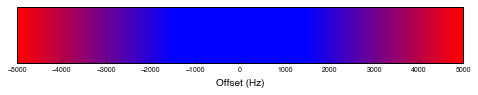

In [9]:
colorList, scalarMap = omega_colors(relativeomega)

plt.figure(figsize=(8,1))
ax1 = plt.subplot(111)
cb = mpl.colorbar.ColorbarBase(ax1, cmap=scalarMap.cmap, 
                               norm=scalarMap.norm, orientation='horizontal')
cb.set_label('Offset (Hz)')

The colormap can also be used to visualize the frequencies that will be animated on a two-dimensional plot of the net effect of the shaped pulse on the magnetization.

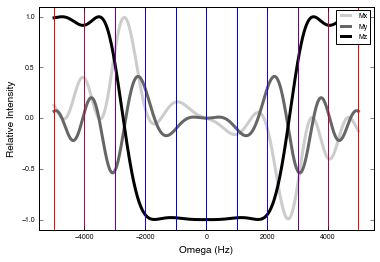

In [10]:
fig = plt.figure()

ax = plt.subplot(111)
ax.plot(relativeomega,xyzdata[0,:,-1],color=(0.8,0.8,0.8,1.0),\
        label='Mx',linewidth=3.0)
ax.plot(relativeomega,xyzdata[1,:,-1],color=(0.4,0.4,0.4,1.0),\
        label='My',linewidth=3.0)
ax.plot(relativeomega,xyzdata[2,:,-1],color=(0.0,0.0,0.0,1.0),\
        label='Mz',linewidth=3.0)
ax.set_xlabel('Omega (Hz)')
ax.set_ylabel('Relative Intensity')
ax.set_xlim(1.1*offset)
ax.set_ylim(-1.1,1.1)
ax.legend()

# Generate the color list using the above function to visualize the frequencies used
# The scalarMap will be used in the animation plot
colorList, scalarMap = omega_colors(relativeomega_S)
for x in range(len(relativeomega_S)):
    ax.plot([relativeomega_S[x],relativeomega_S[x]],[-1.1,1.1],color=colorList[x])

Matplotlib doesn't have a specific type of three-dimensional axes for plotting vectors on a sphere, so I created a function that will setup one to my liking. Because Matplotlib's text annotation function does not work with three-dimensional axes, a transformation has to be made to calculate the two-dimensional position based on perspective. I am continually amazed by the power of [transformations](http://wiki.scipy.org/Cookbook/Matplotlib/Transformations) in Matplotlib, and they're worth learning more about.

In [11]:
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d import proj3d

def circular_axes(fig, title='', elev=20, azim=30):
    # Create a 3D figure
    ax = fig.gca(projection='3d')
    
    # Draw axes lines
    ax.plot([-1,1], [0,0], [0,0], 'gray')
    ax.plot([0,0], [-1,1], [0,0], 'gray')
    ax.plot([0,0], [0,0], [-1,1], 'gray')
    
    # Draw a gray circle in xy-plane
    npoints = 100
    ang = np.linspace(0,2*np.pi,npoints)
    xcir = np.cos(ang)
    ycir = np.sin(ang)
    zcir = np.zeros((npoints,))
    ax.plot(xcir,ycir,zcir,'gray')
    # Uncomment to draw circular axes limits for other planes
    #ax.plot(zcir,xcir,ycir,'gray') # Circular permutations!
    #ax.plot(ycir,zcir,xcir,'gray')
    
    # Hide the gray background and set perspective
    ax.set_axis_off()
    ax.view_init(elev,azim)
    
    # Can't use axis_label commands because they will label in the wrong spot
    # Annotation commands only work on 2D plots, but can use in 3D plots if
    # the 2D projection is calculated
    xs_x, ys_x, _ = proj3d.proj_transform(1, 0,0, ax.get_proj())
    xs_y, ys_y, _ = proj3d.proj_transform(0, 1,0, ax.get_proj())
    xs_z, ys_z, _ = proj3d.proj_transform(0, 0,1, ax.get_proj())
    xs_t, ys_t, _ = proj3d.proj_transform(0.5, -1.0, 1, ax.get_proj())
    
    # Label the axes with the calculated 2D points
    ax.annotate('X', xy=(xs_x,ys_x), xycoords='data', xytext=(-12,-10),
                textcoords='offset points', fontweight='bold', label='xaxis')
    ax.annotate('Y', xy=(xs_y,ys_y), xycoords='data', xytext=(10,-10),
                textcoords='offset points', fontweight='bold', label='yaxis')
    ax.annotate('Z', xy=(xs_z,ys_z), xycoords='data', xytext=(8,8),
                textcoords='offset points', fontweight='bold', label='zaxis')
    ax.annotate(title, xy=(xs_t,ys_t), xycoords='data', xytext=(-10,8),
                textcoords='offset points', fontweight='bold', label='title')
    
    return ax

Let's see what these axes look like.

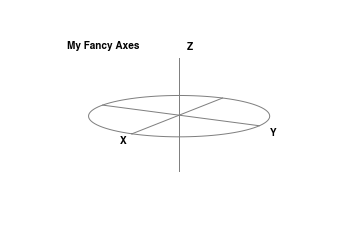

In [12]:
f = plt.figure()
f.set_facecolor((1.0, 1.0, 1.0, 1.0))
ax = circular_axes(f, 'My Fancy Axes')

For vectors plotted on a sphere, I prefer the aesthetic of arrows to simple lines. This is an adaptation of a [class](http://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector) written to plot arrows on three-dimensional axes. I added a subroutine for updating the position of an existing arrow as well as a way to create a figure legend for the arrows if desired.

In [13]:
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        # Probably a cleaner way to save kwargs...
        self._label = '_nolegend_'
        if 'label' in kwargs.keys():
            self._label = kwargs['label']
        self._color = 'black'
        if 'color' in kwargs.keys():
            self._color = kwargs['color']
        # Add invisible line for legend
        ax = plt.gca() # Prefer to update in 'draw' but it doesn't work
        ax.plot3D([0,0], [0,0], [0,0], 
                  linewidth=1.0, label=self._label, color=self._color)

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]), (xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
    
    # This will update the arrow position
    def set_data3d(self, xs3d, ys3d, zs3d):
        ax = self.axes
        rendererM = ax.get_proj()
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, rendererM)
        self._verts3d = xs3d, ys3d, zs3d
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

Let's see what this looks like with a single arrow drawn.

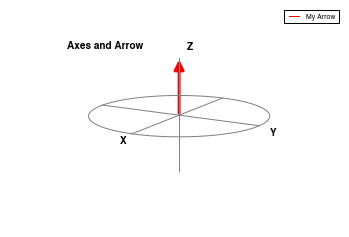

In [14]:
f = plt.figure()
f.set_facecolor((1.0, 1.0, 1.0, 1.0))
ax = circular_axes(f,'Axes and Arrow')
arrow = Arrow3D([0,0], [0,0], [0,1] ,mutation_scale=20, lw=3.0, \
                    arrowstyle='-|>', color='red', label='My Arrow')
ax.add_artist(arrow)
_ = ax.legend()

The last function to declare is for the animation itself--the position of the arrows needs to be updated with each time step. Additionally, it would be nice to be able to rotate the axes at various times. Note that the rotation must be performed before moving the arrows because the position of the arrows is calculated from their projection onto the two-dimensional figure containing the axes.

In [15]:
def update_pos(time, data, arrowList, elevL, azimL):
    elev = elevL[time]
    azim = azimL[time]
    xyz = data[:,:,time]
    
    # Rotate the axis
    ax = arrowList[0].axes
    ax.view_init(elev,azim)
    
    # Move the axis labels with the axis
    ## First get the new projected position
    xs_x, ys_x, _ = proj3d.proj_transform(1,0,0, ax.get_proj())
    xs_y, ys_y, _ = proj3d.proj_transform(0,1,0, ax.get_proj())
    xs_z, ys_z, _ = proj3d.proj_transform(0,0,1, ax.get_proj())
    ## Find the axis labels
    annList = np.array([x for x in ax.get_children() if type(x)==mpl.text.Annotation])
    labList = np.array([x.get_label() for x in annList])
    xaxLab = annList[np.argwhere(labList=='xaxis')[0][0]]
    yaxLab = annList[np.argwhere(labList=='yaxis')[0][0]]
    zaxLab = annList[np.argwhere(labList=='zaxis')[0][0]]
    ## And move them
    xaxLab.xy = (xs_x,ys_x)
    yaxLab.xy = (xs_y,ys_y)
    zaxLab.xy = (xs_z,ys_z)
    
    # Move the arrows
    for x in range(len(arrowList)):
        arrowList[x].set_data3d([0, xyz[0,x]], [0,xyz[1,x]], [0,xyz[2,x]])

Now we're ready to create the animation.


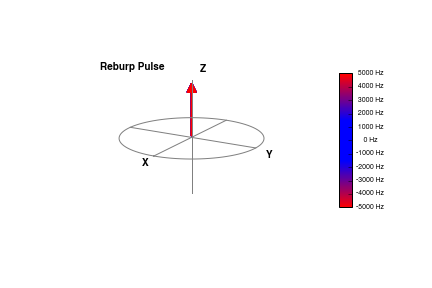
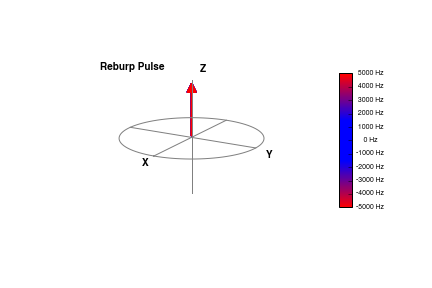
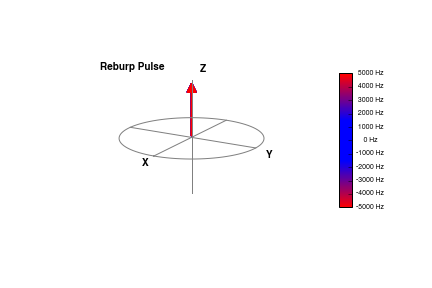
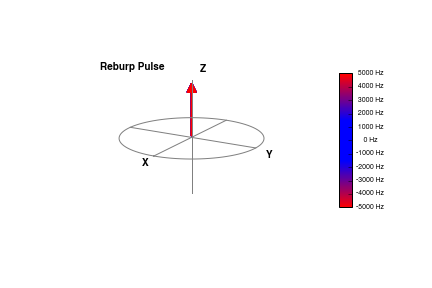
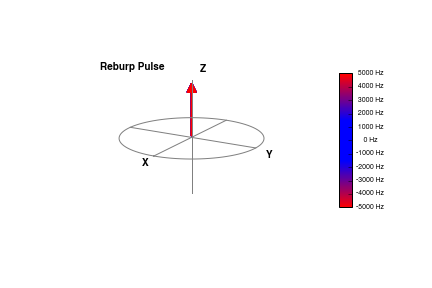
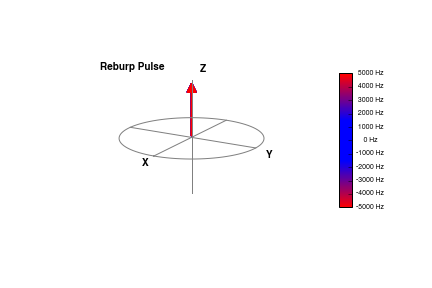
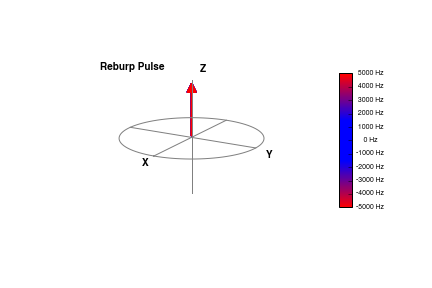
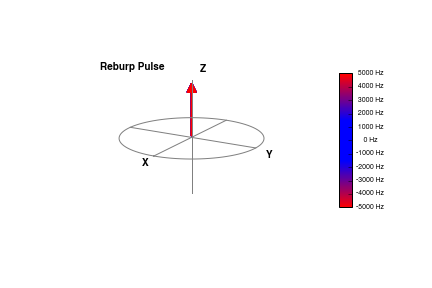
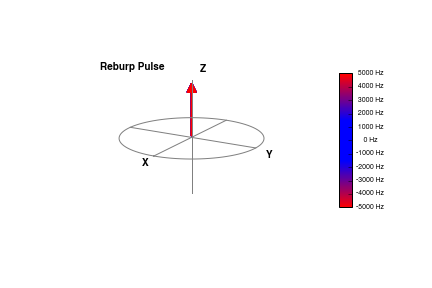
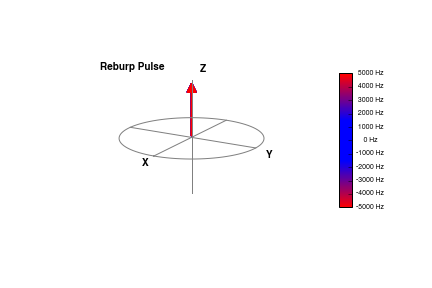
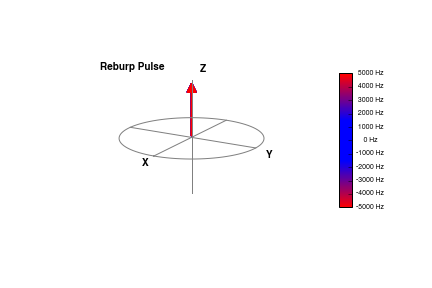
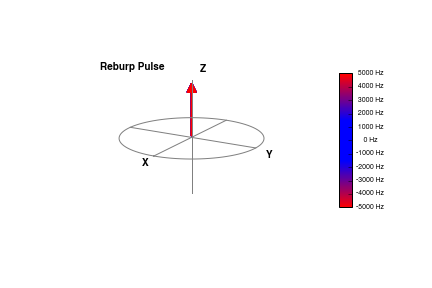
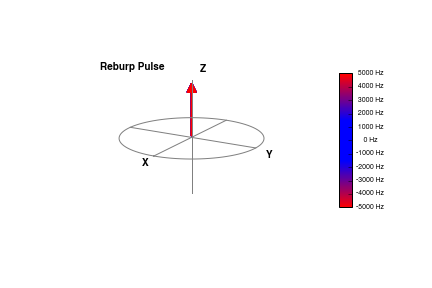
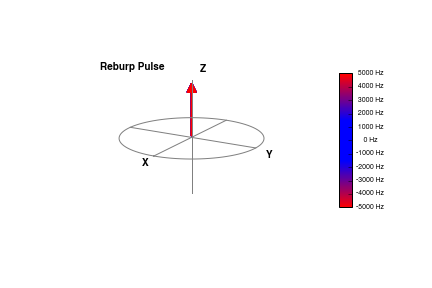
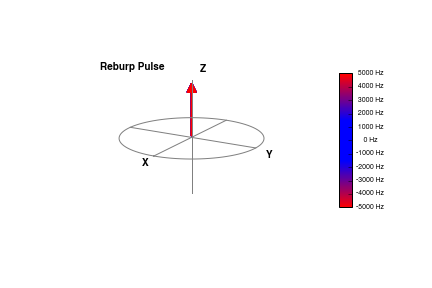
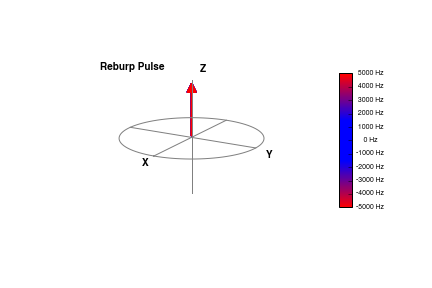
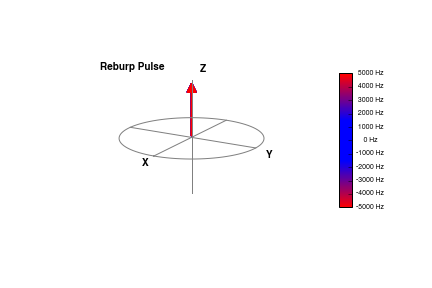
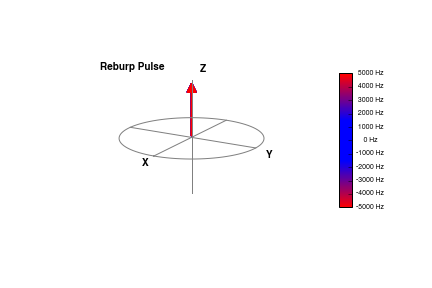
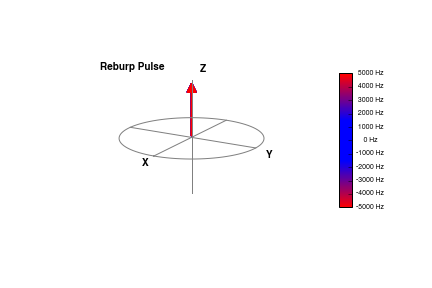
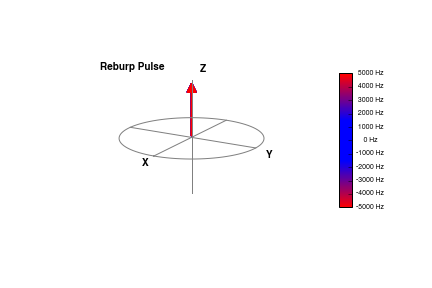
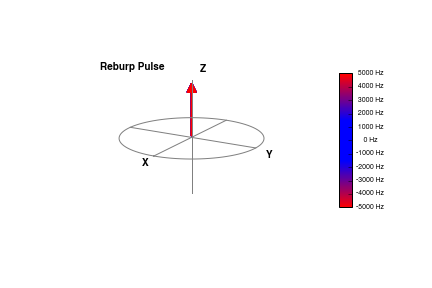
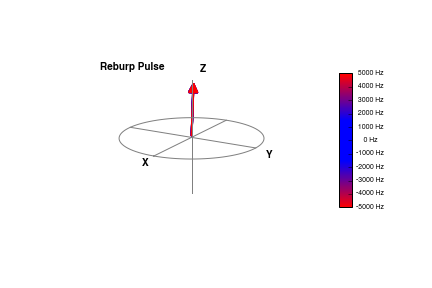
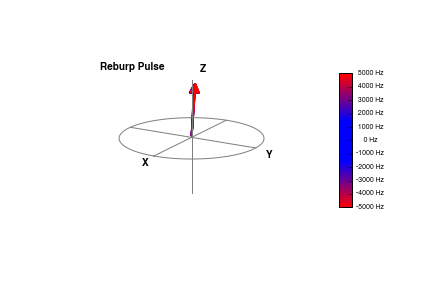
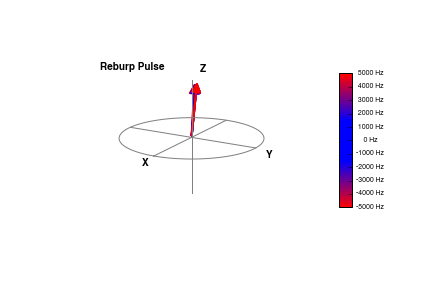
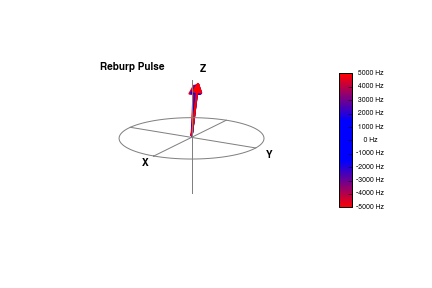
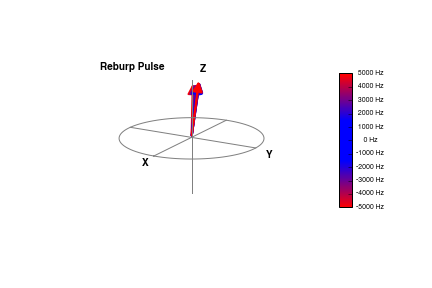
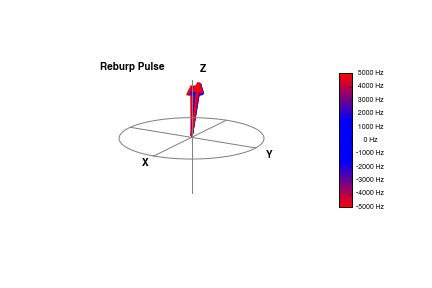
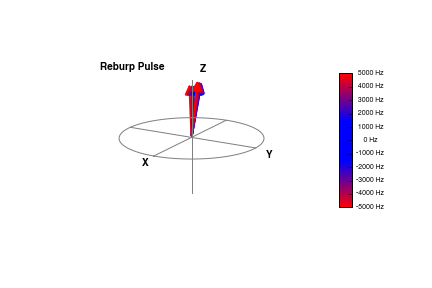
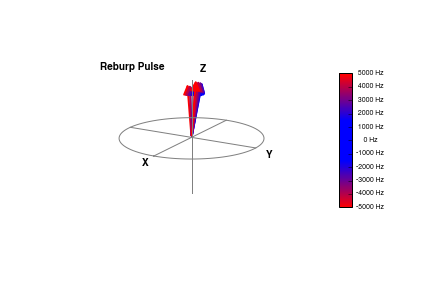
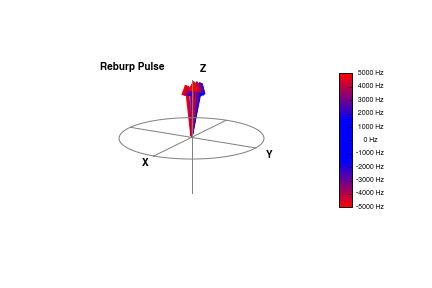
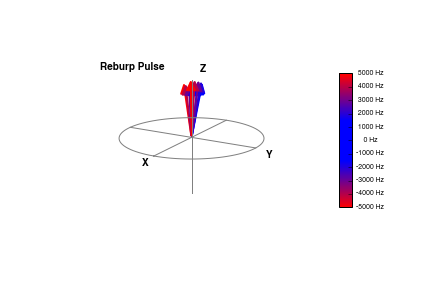
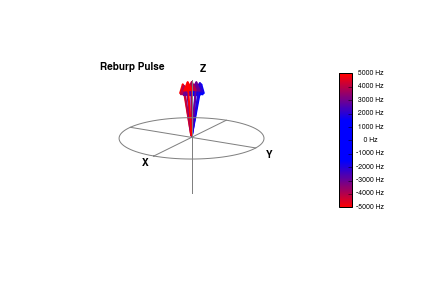
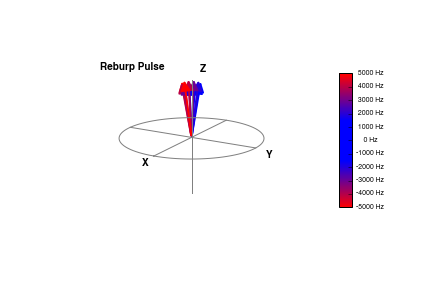
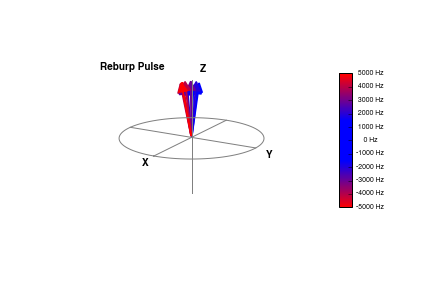
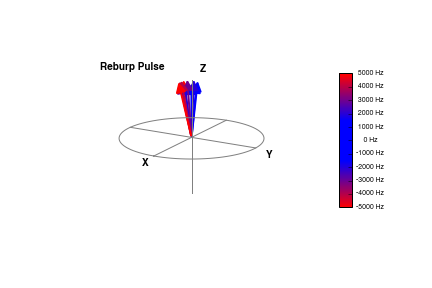
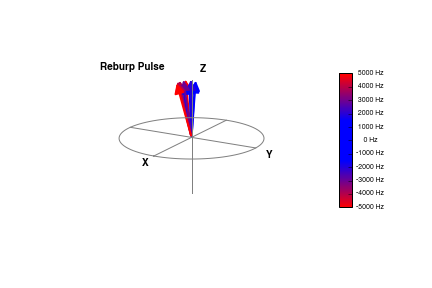
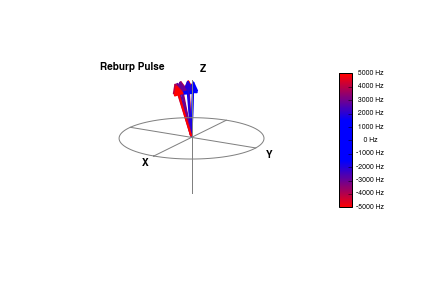
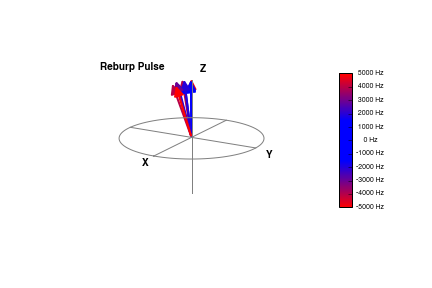
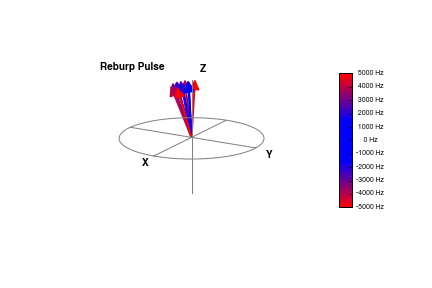
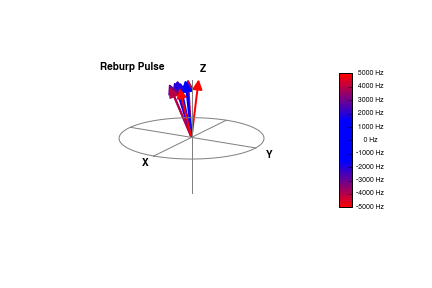
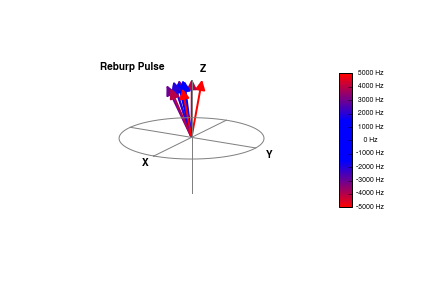
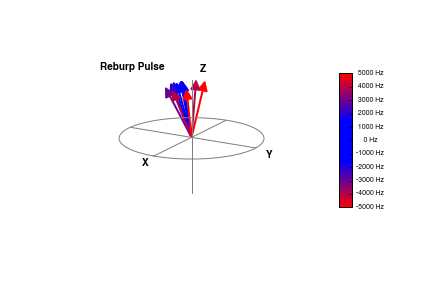
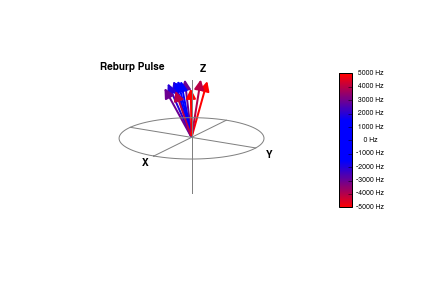
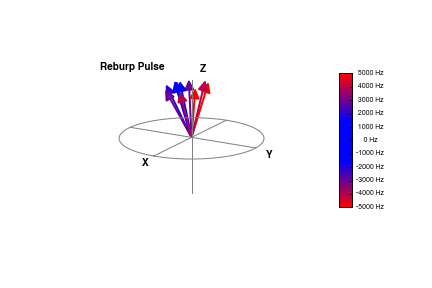
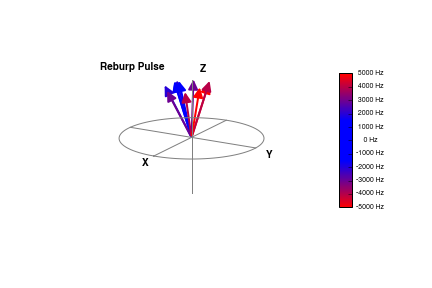
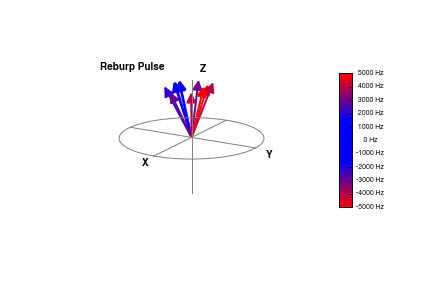
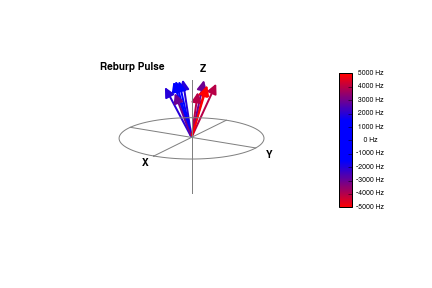
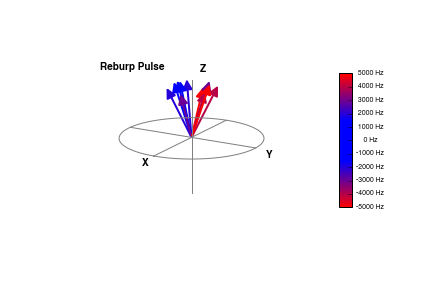
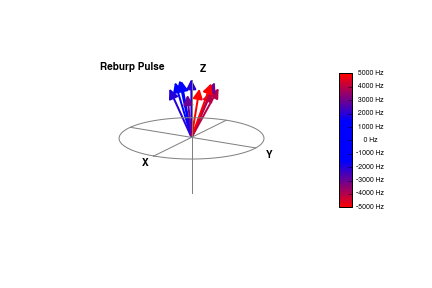
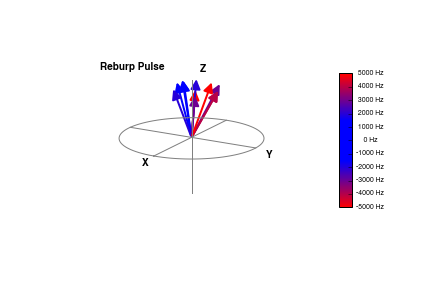
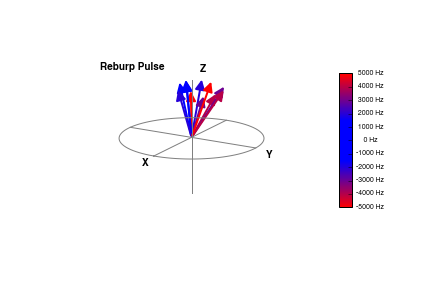
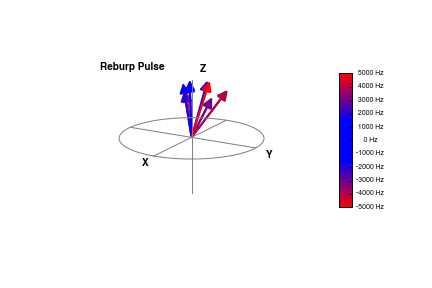
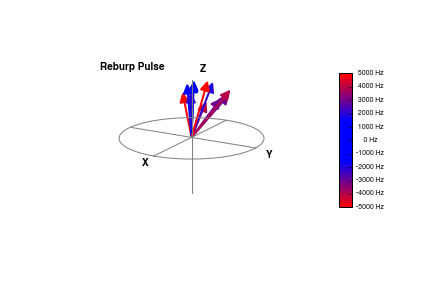
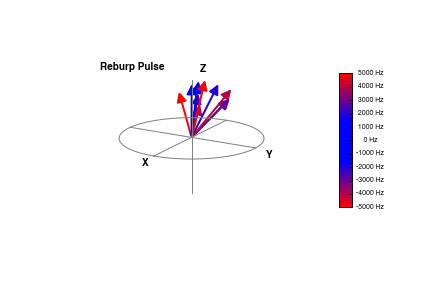
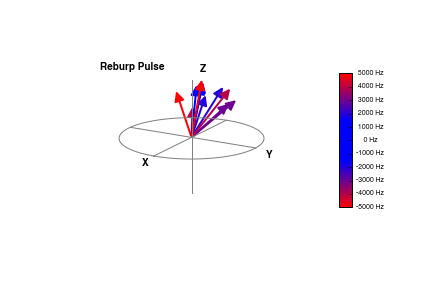
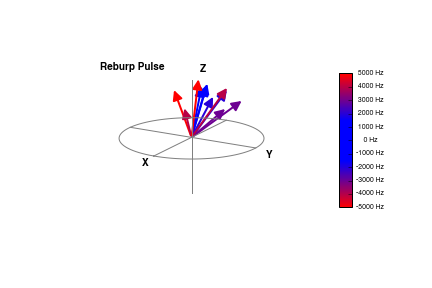
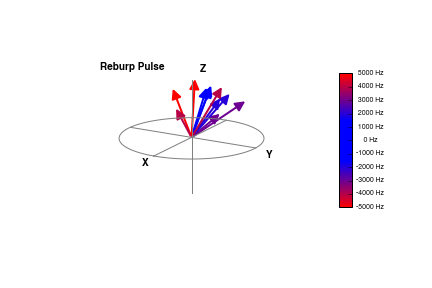
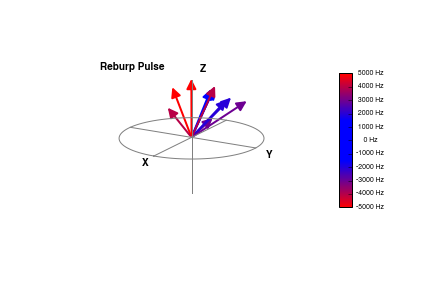
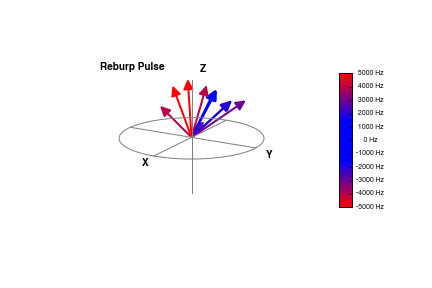
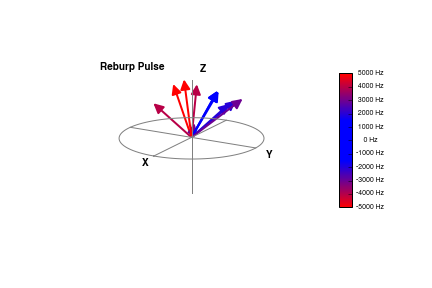
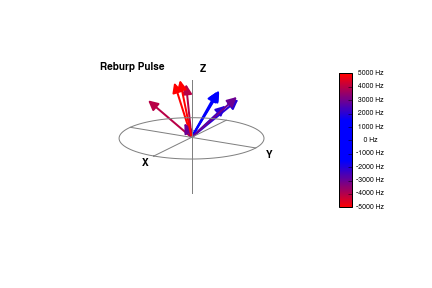
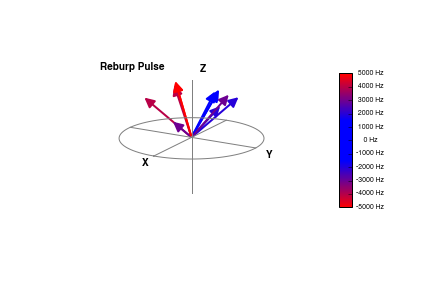
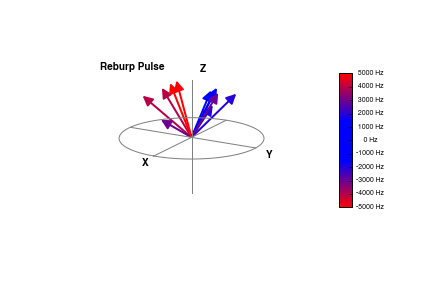
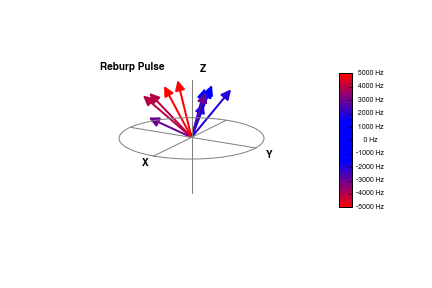
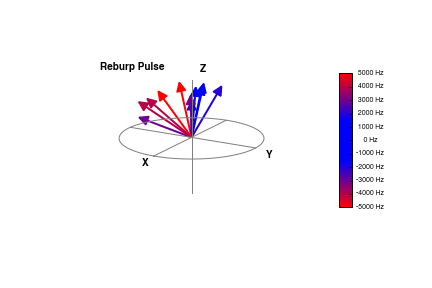
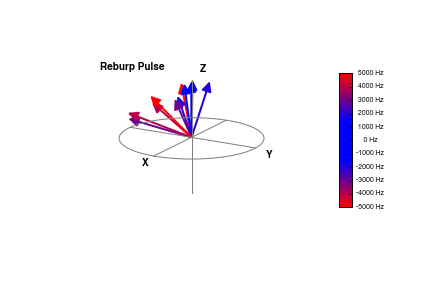
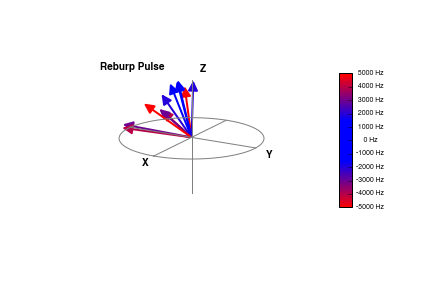
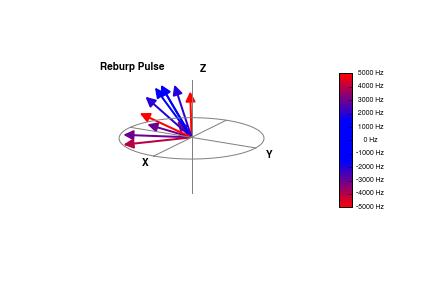
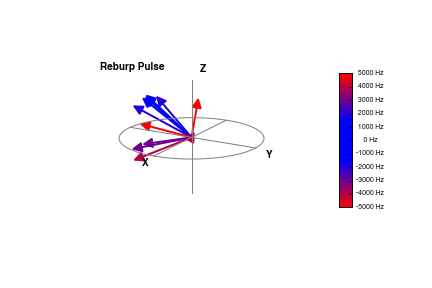
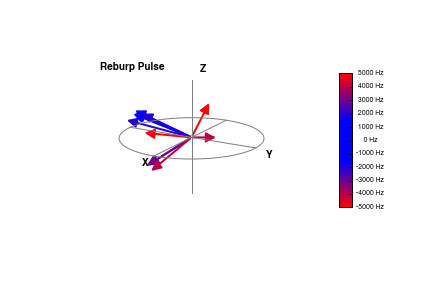
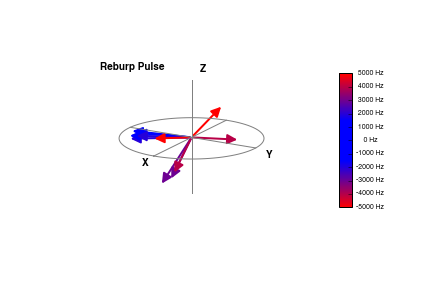
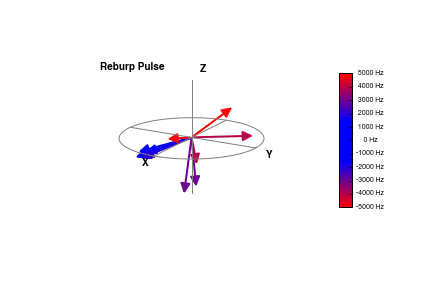
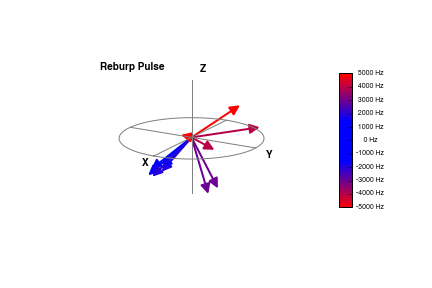
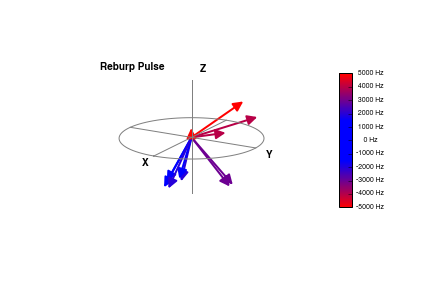
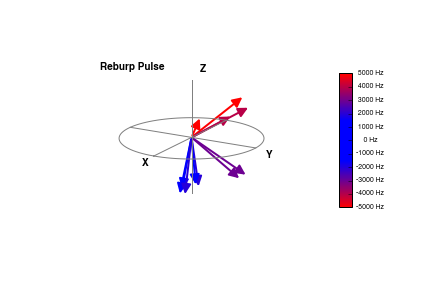
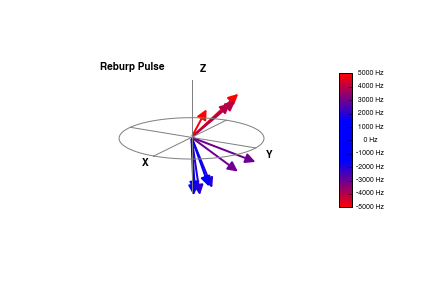
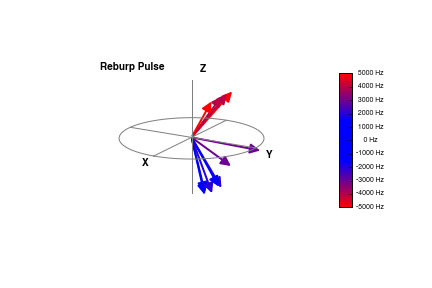
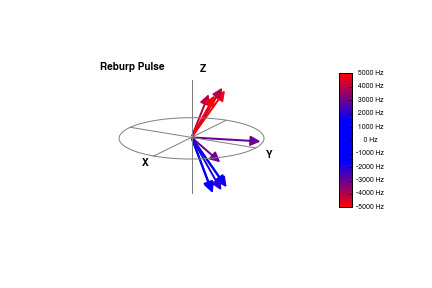
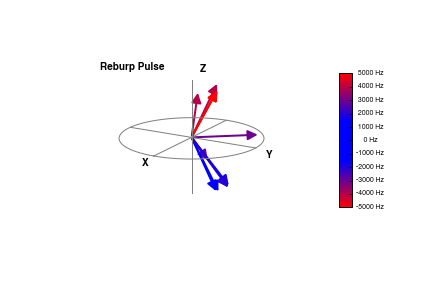
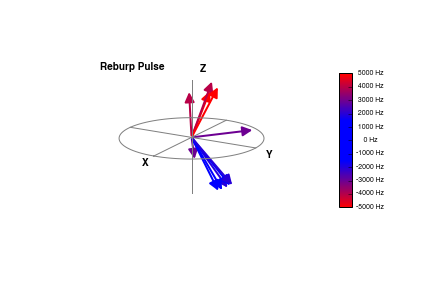
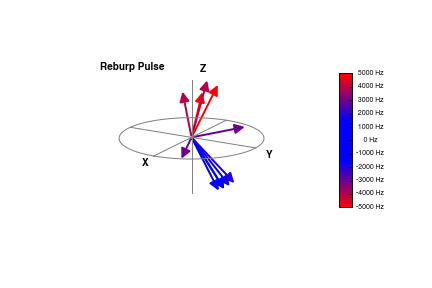
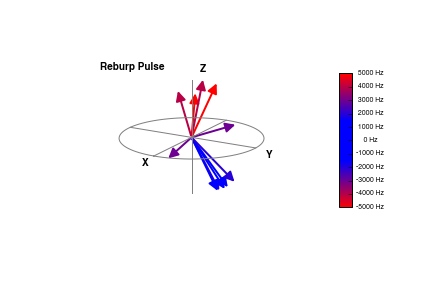
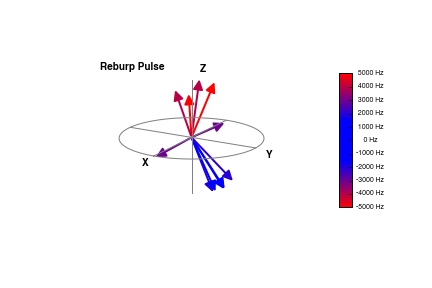
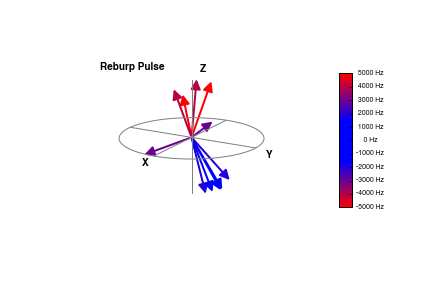
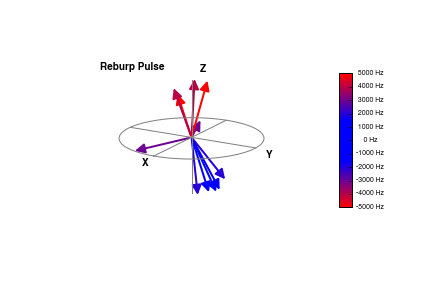
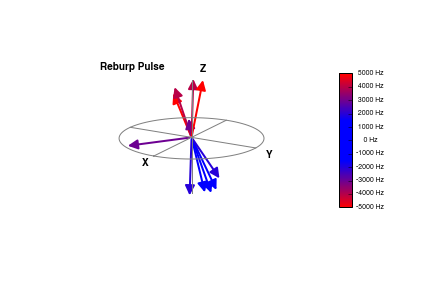
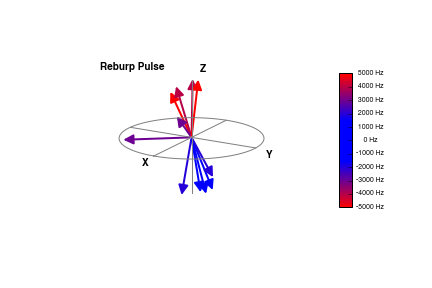
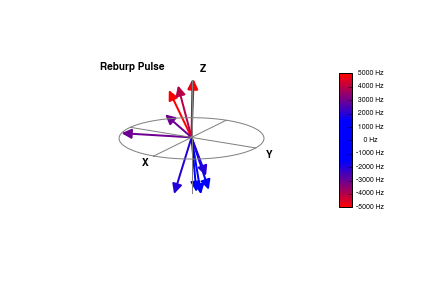
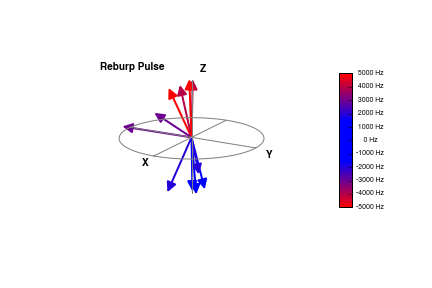
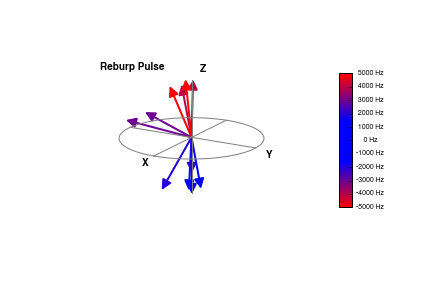
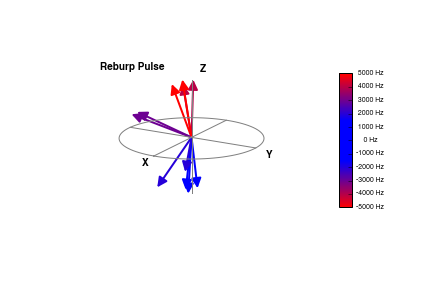
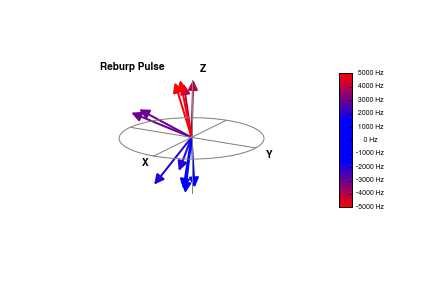
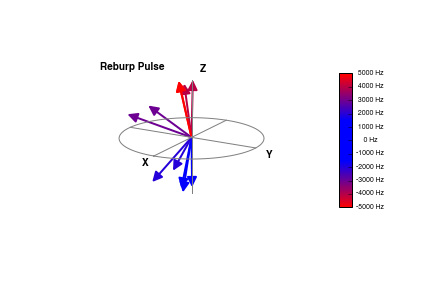
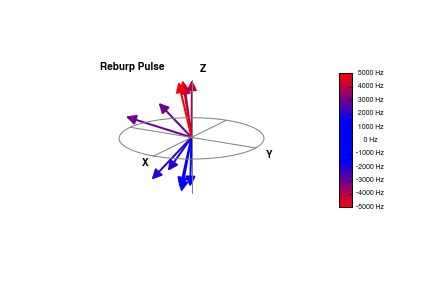
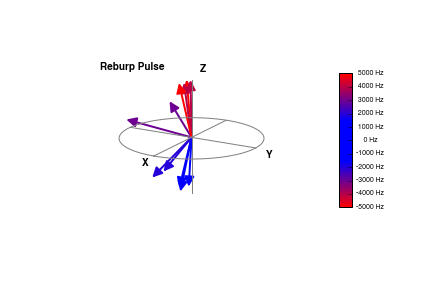
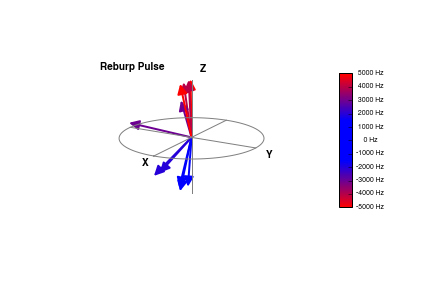
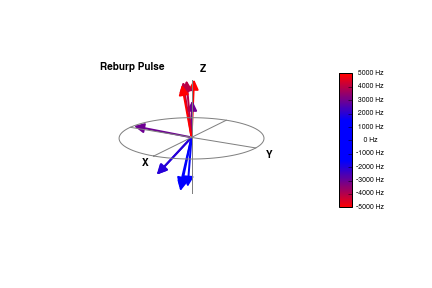
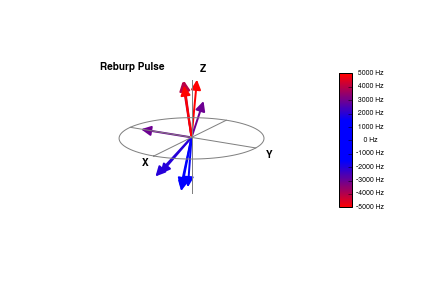
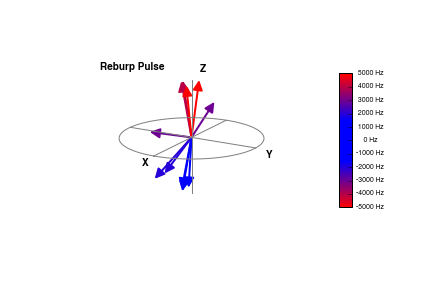
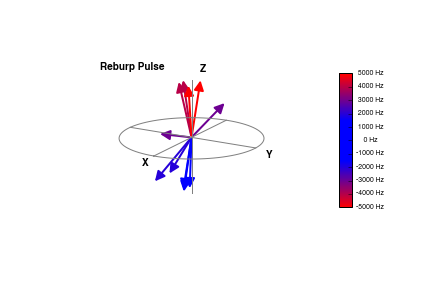
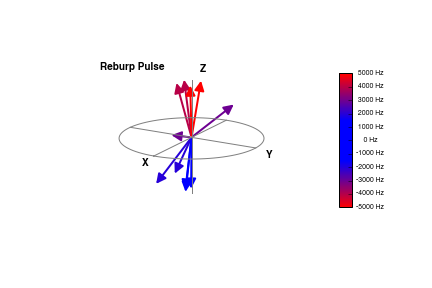
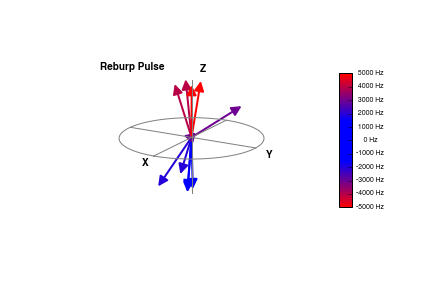
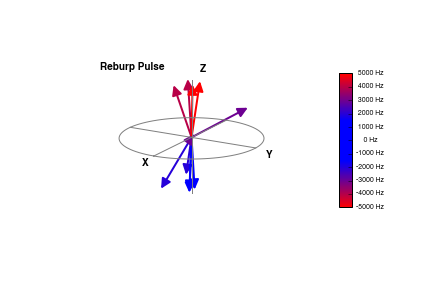
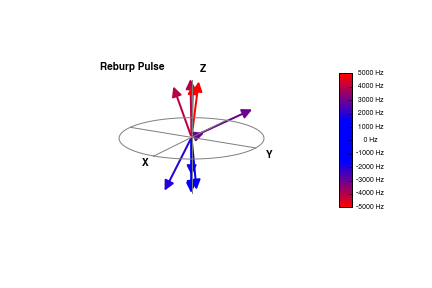
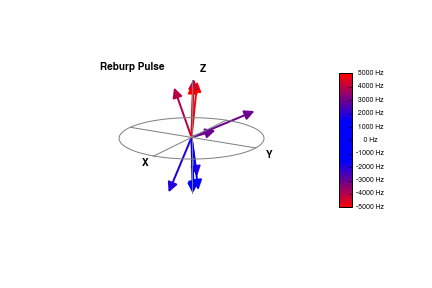
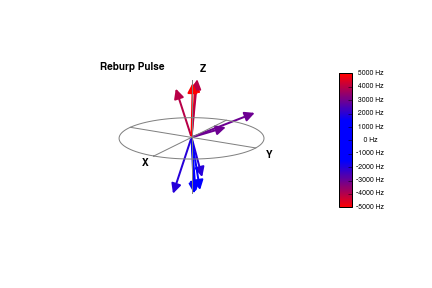
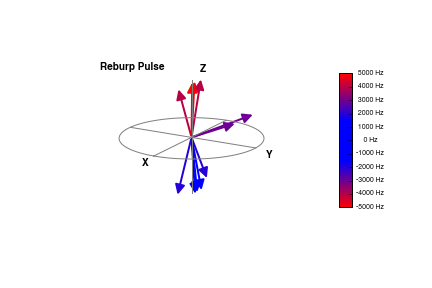
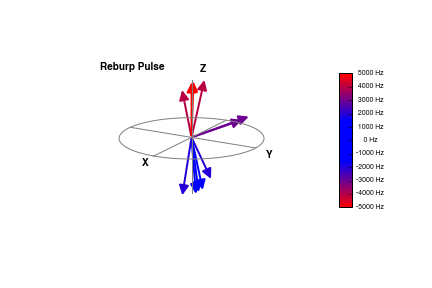
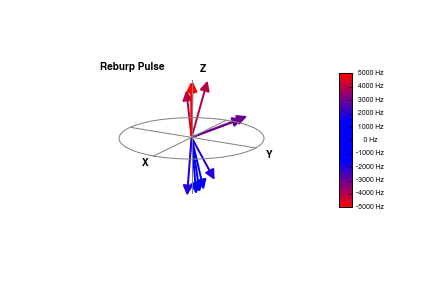
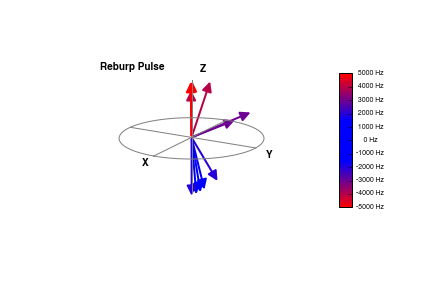
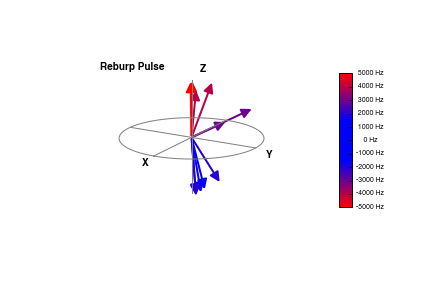
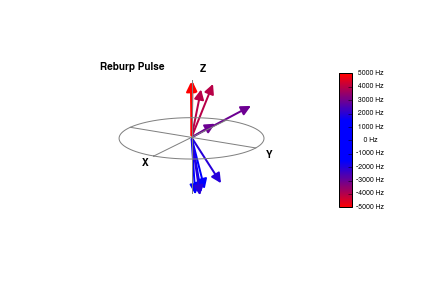
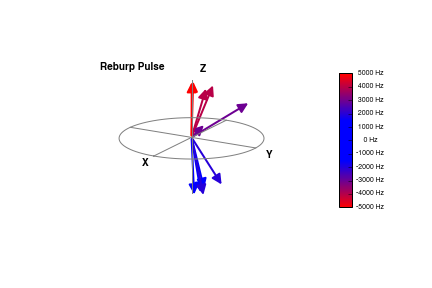
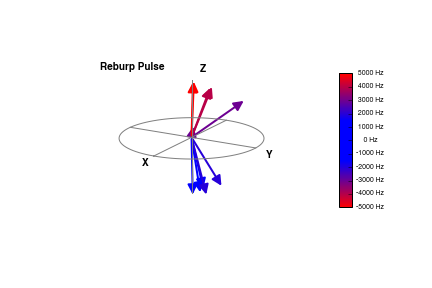
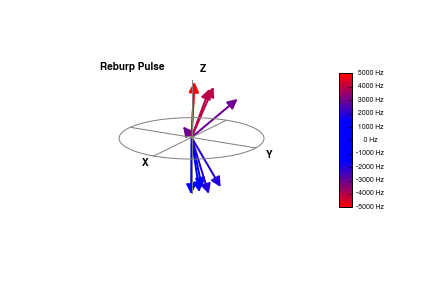
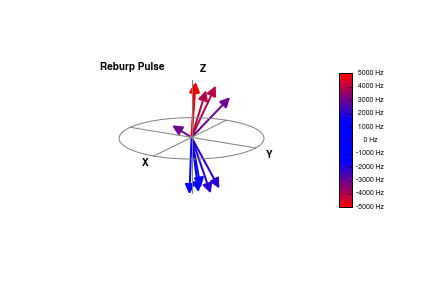
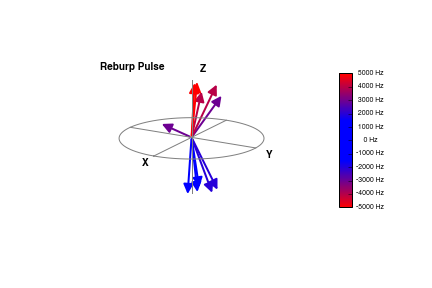
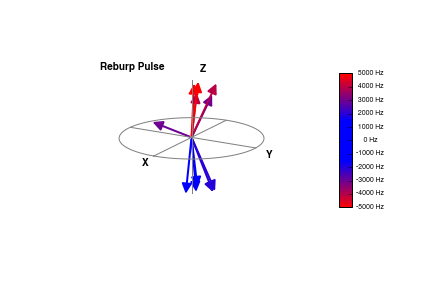
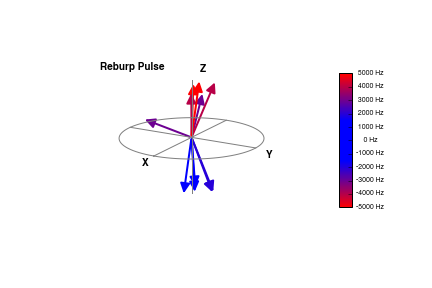
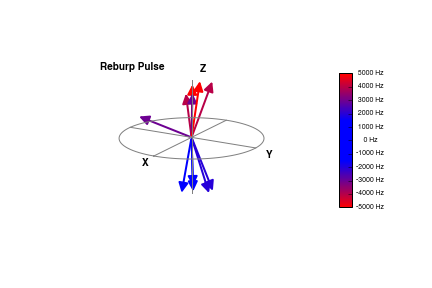
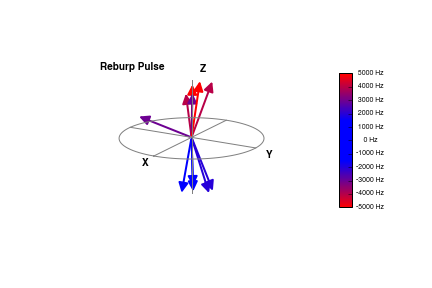
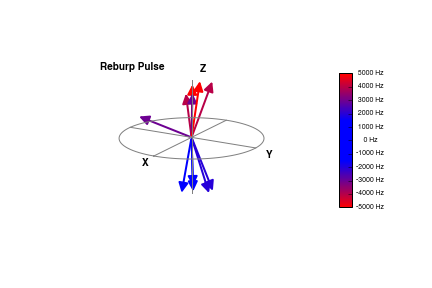
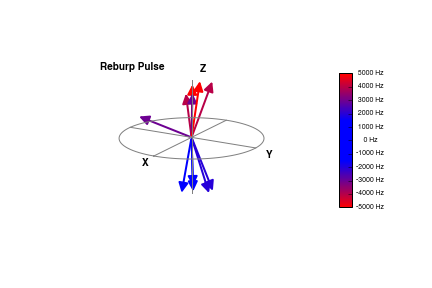
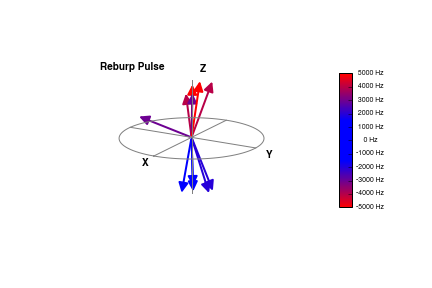
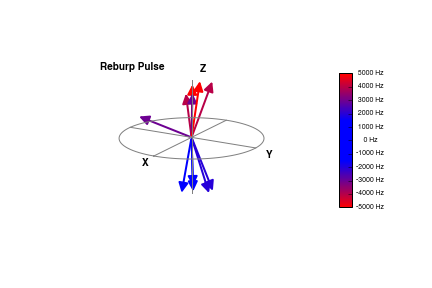
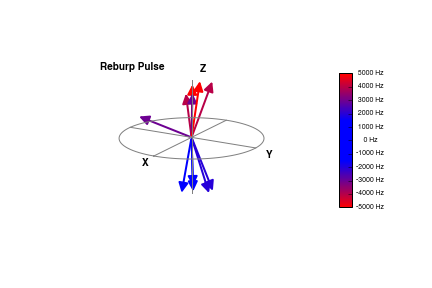
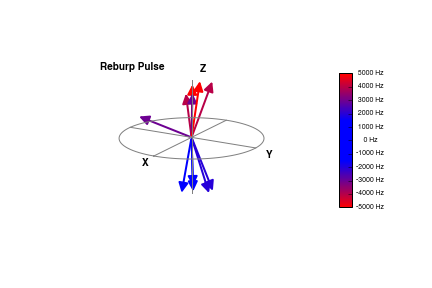
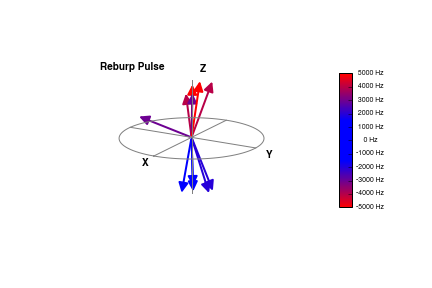
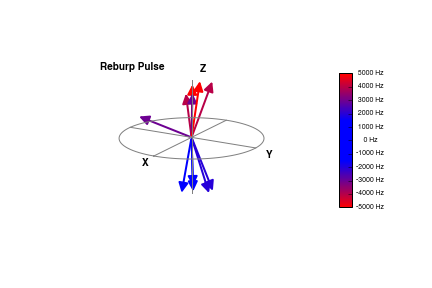
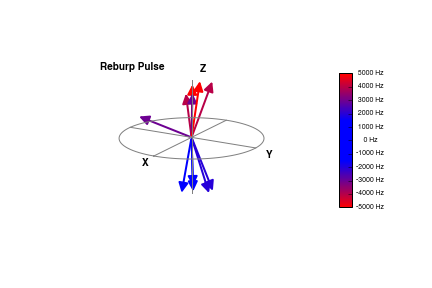
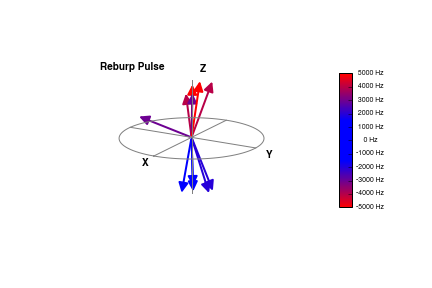
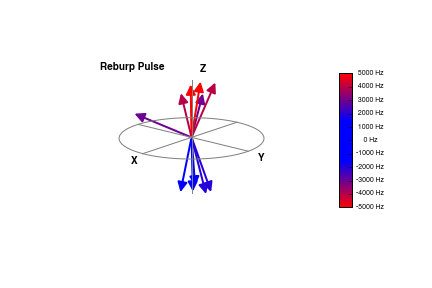
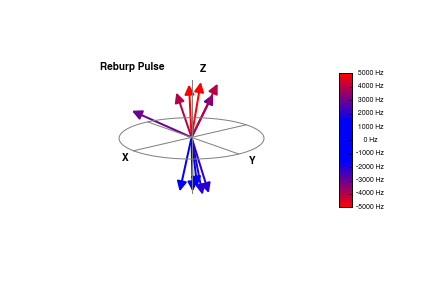
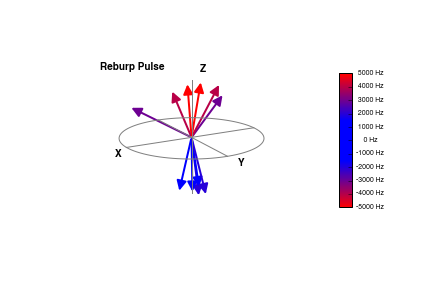
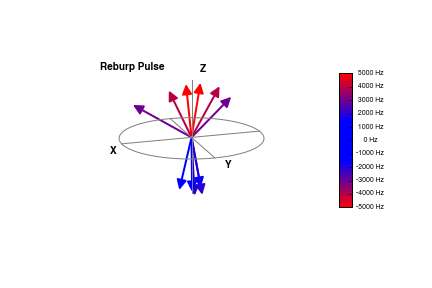
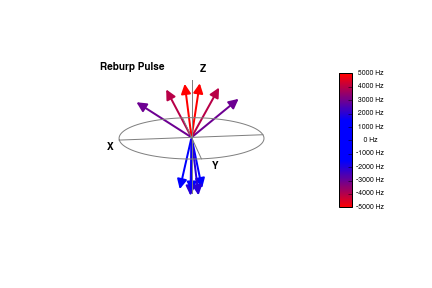
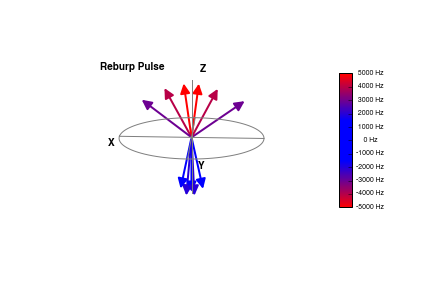
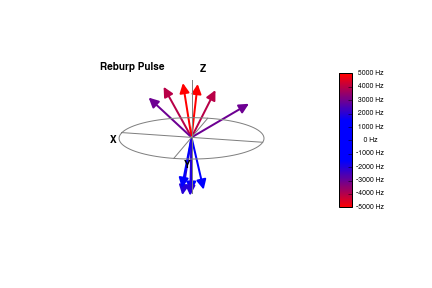
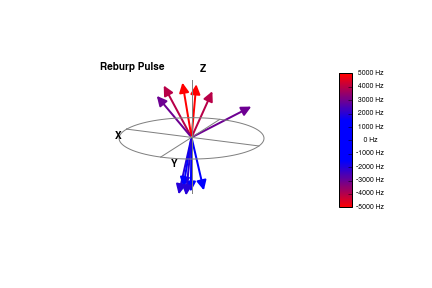
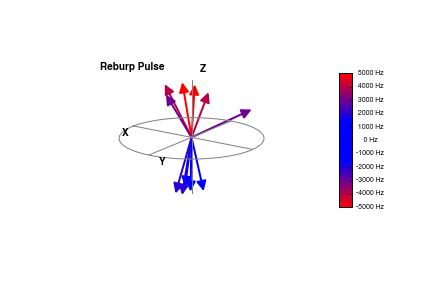
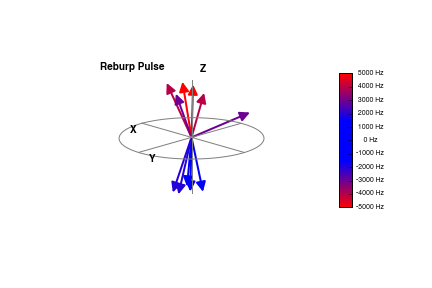
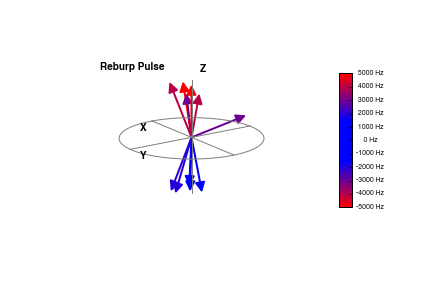
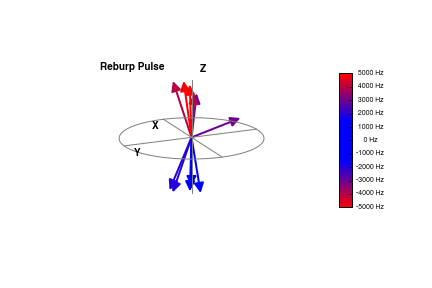
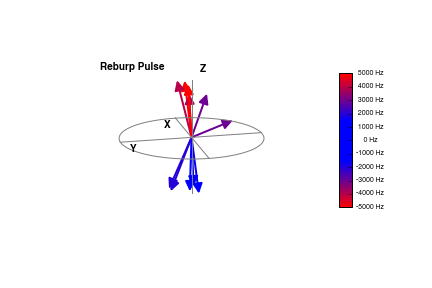
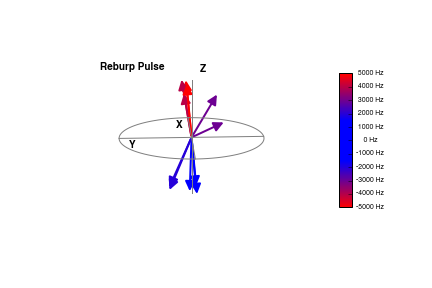
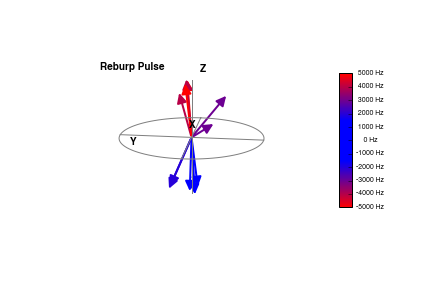
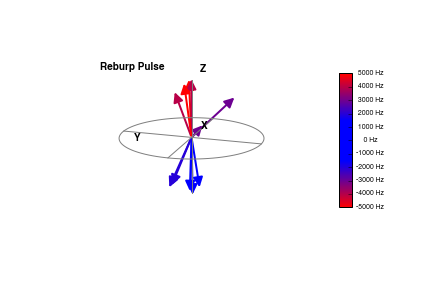
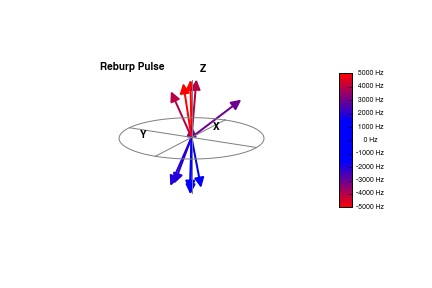
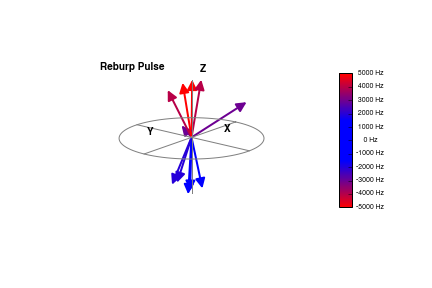
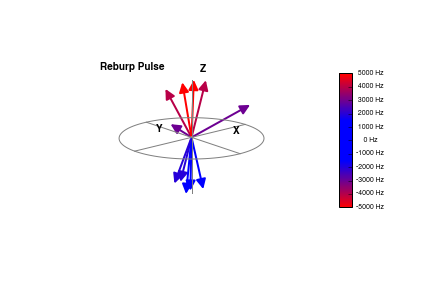
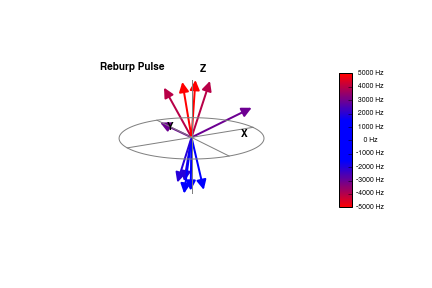
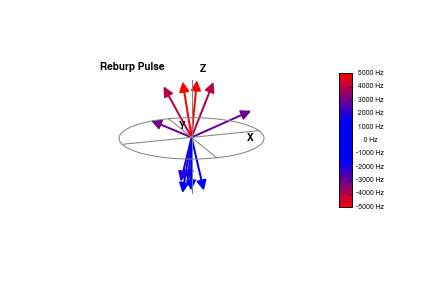
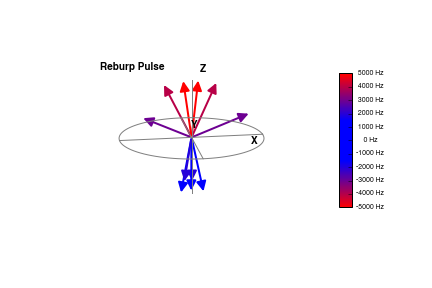
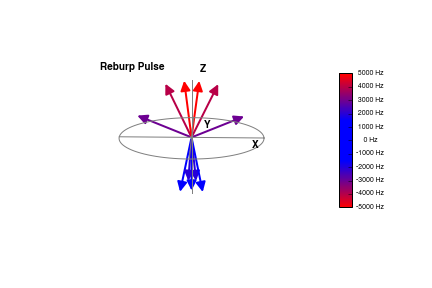
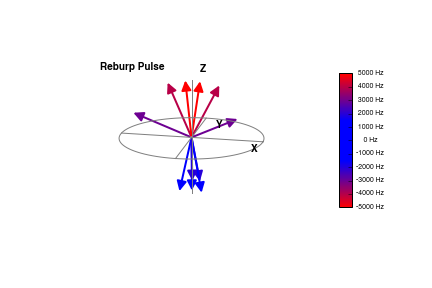
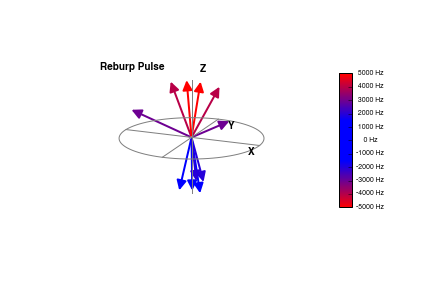
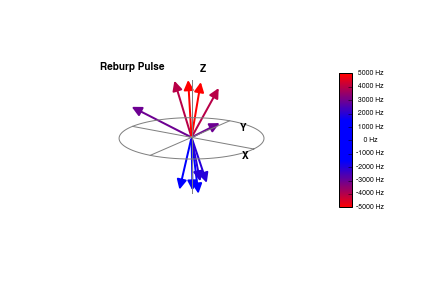
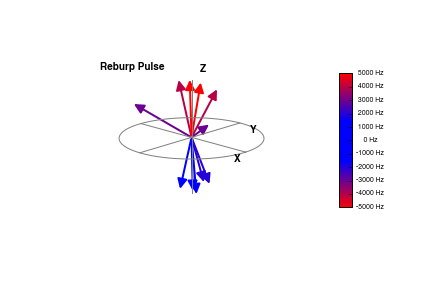
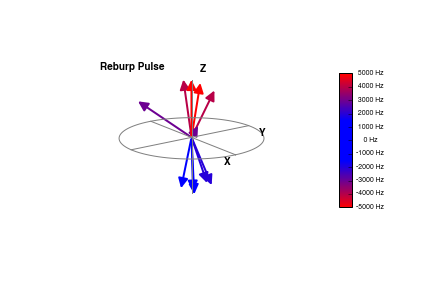
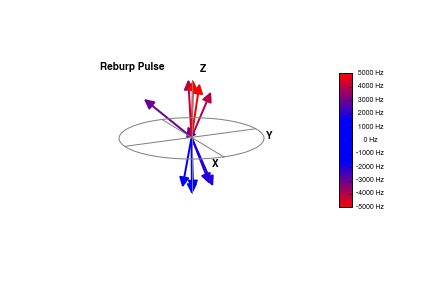
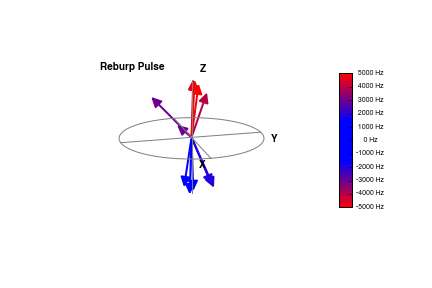
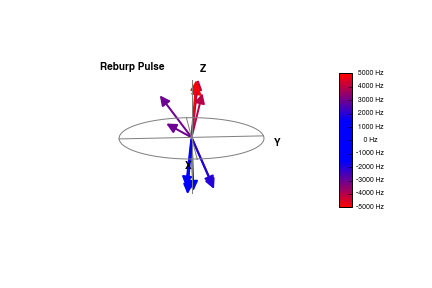
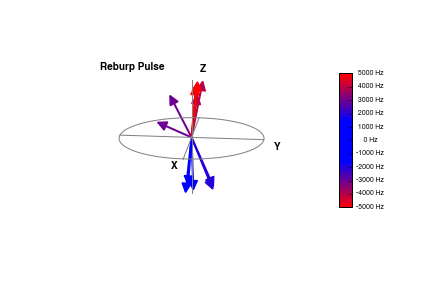
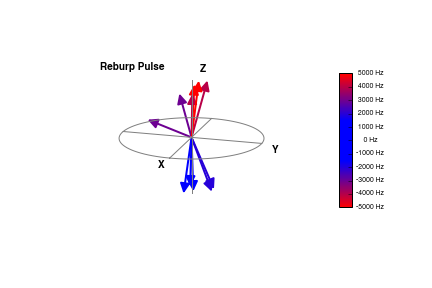
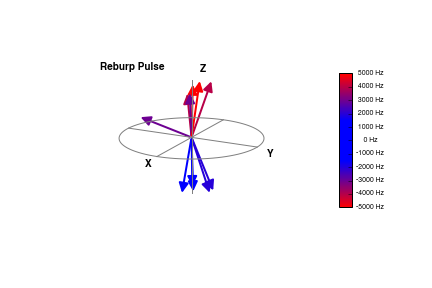
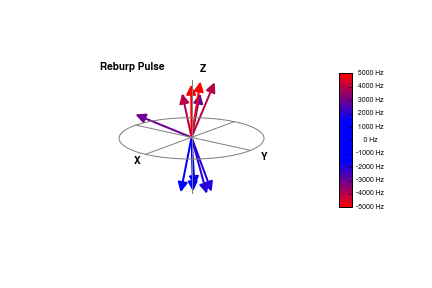
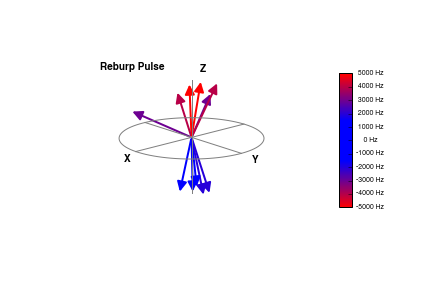
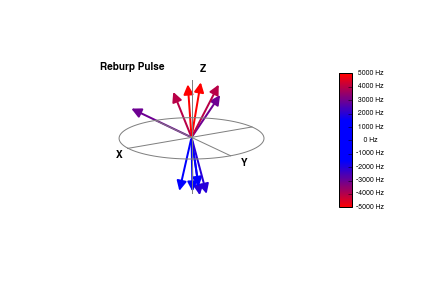
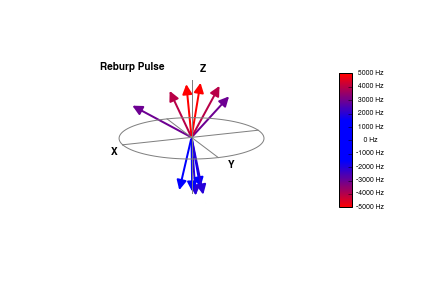
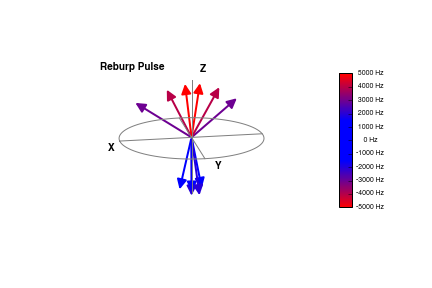
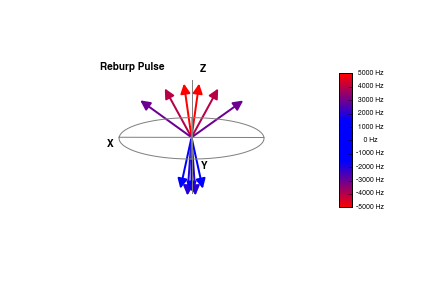
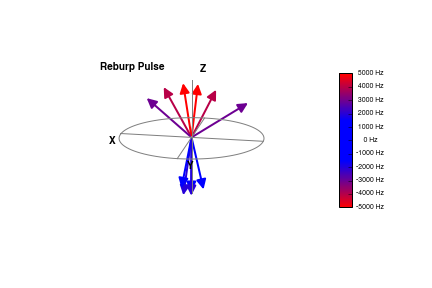
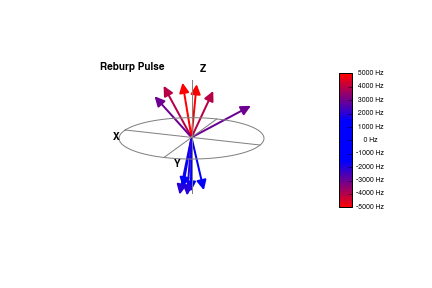
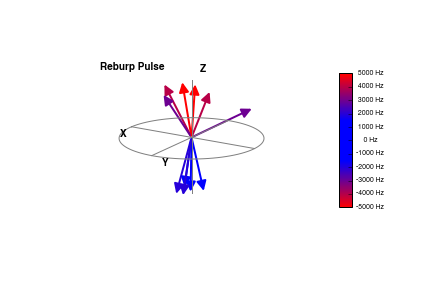
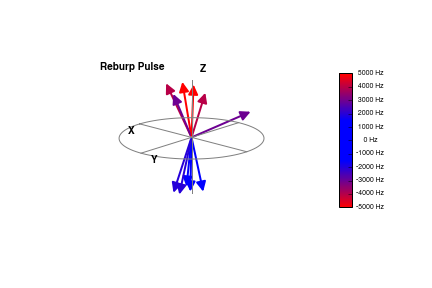
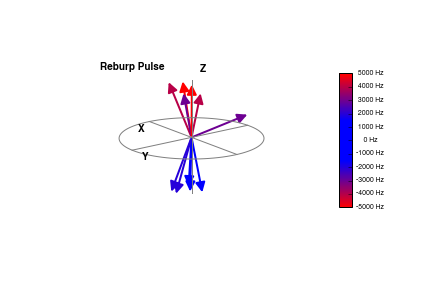
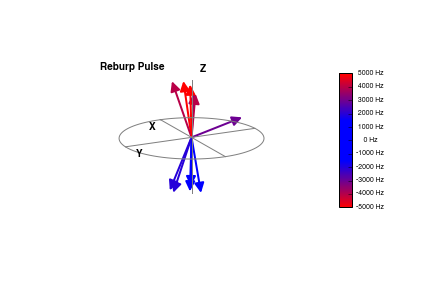
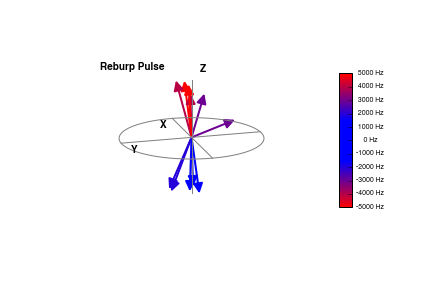
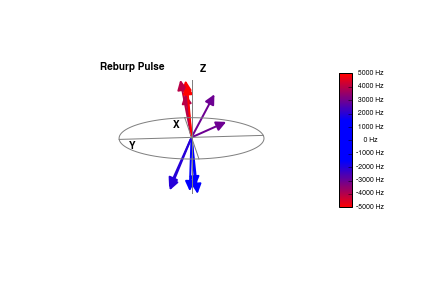
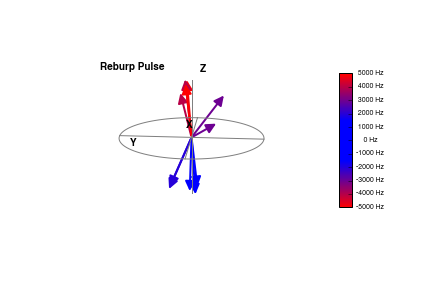
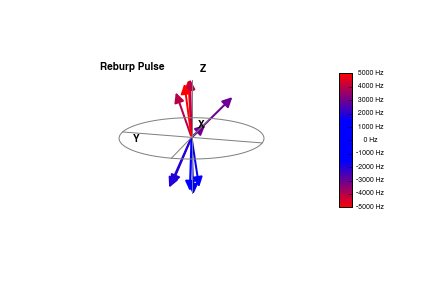
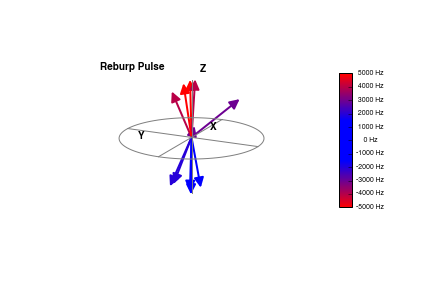
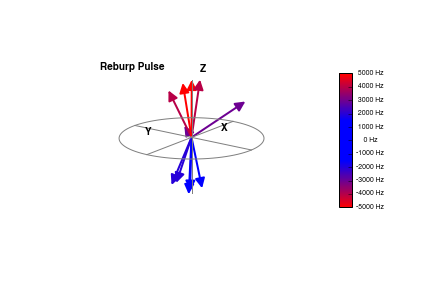
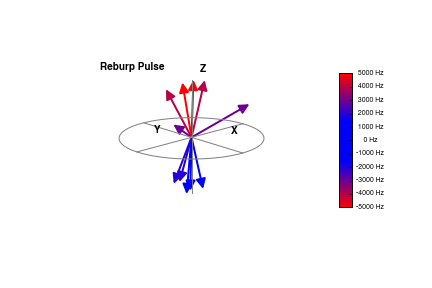
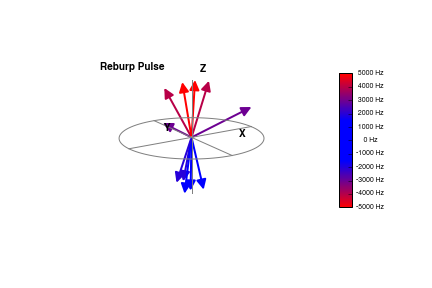
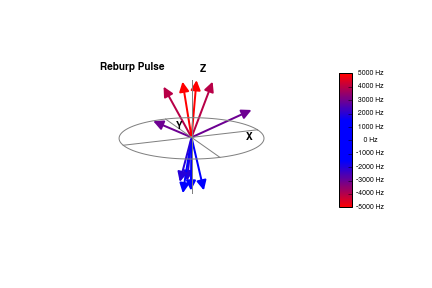
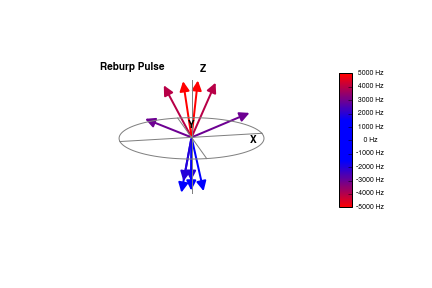
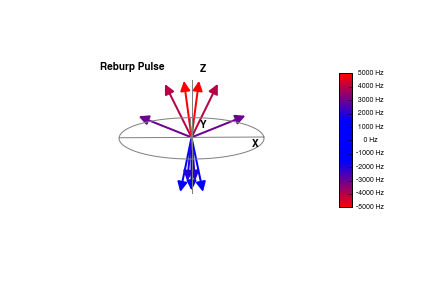
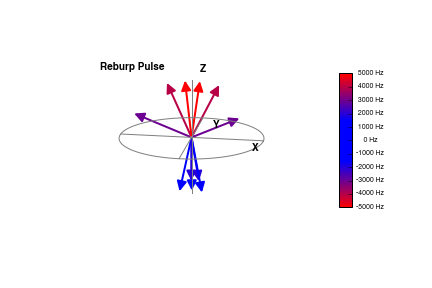
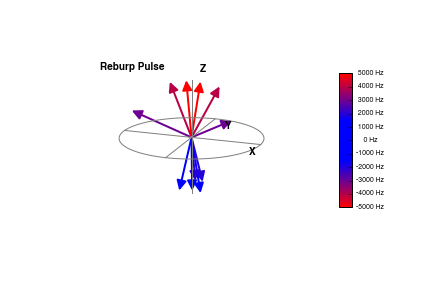
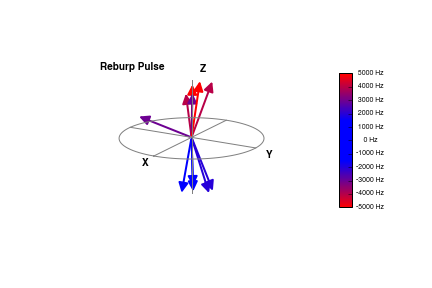
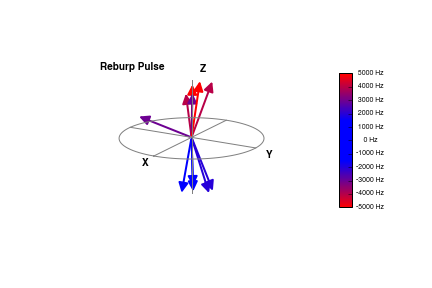
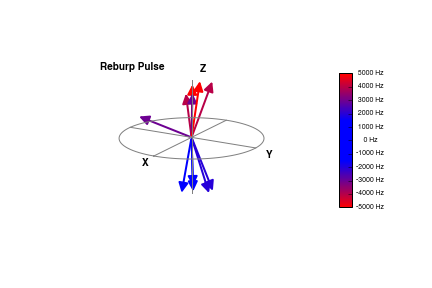
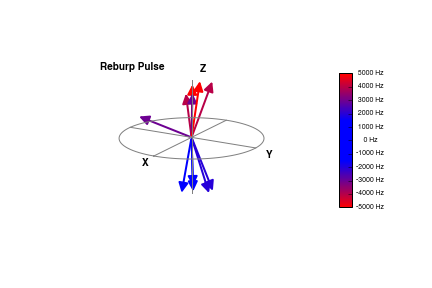
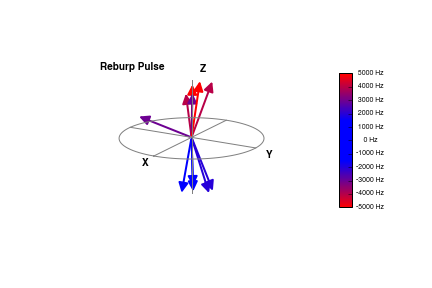
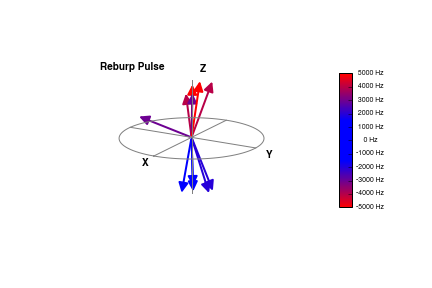
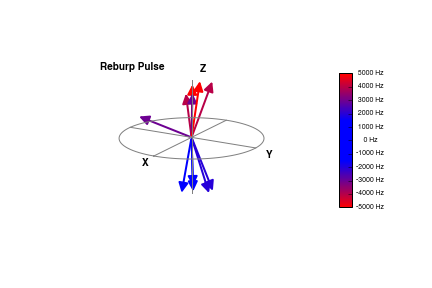
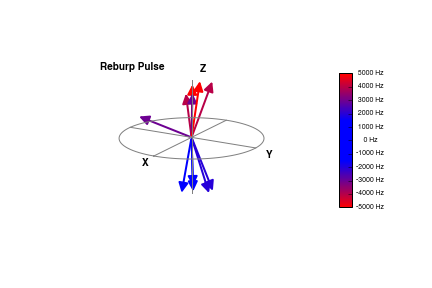
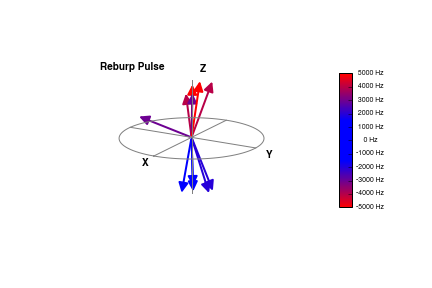
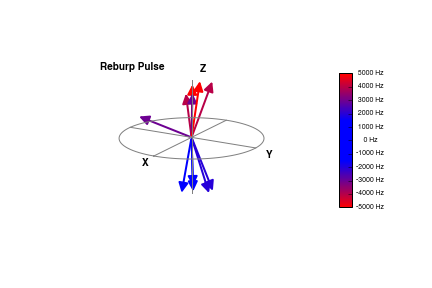
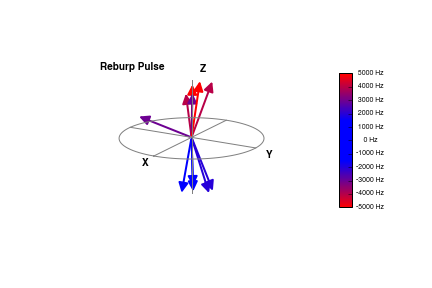
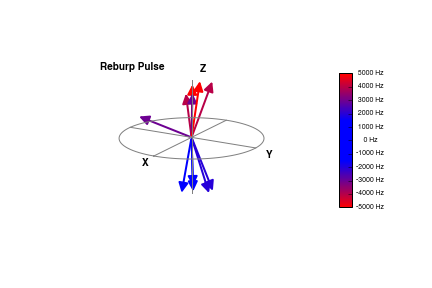
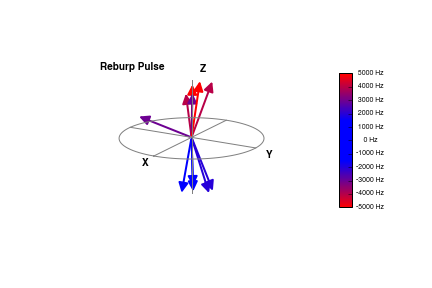
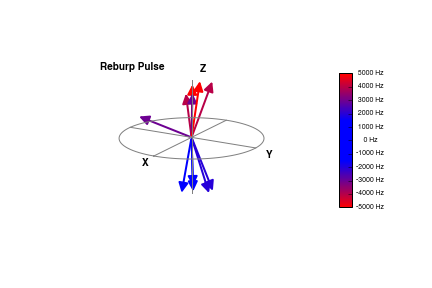
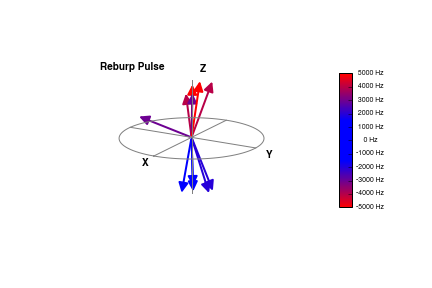
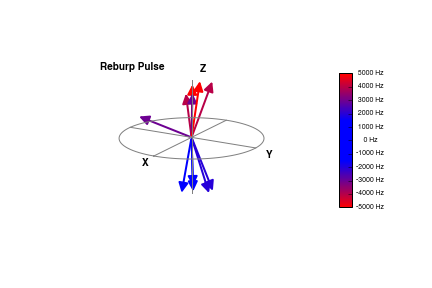
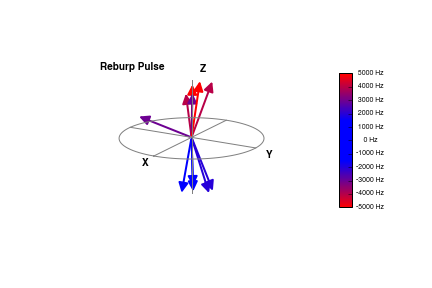
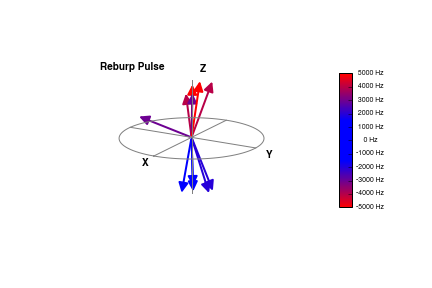
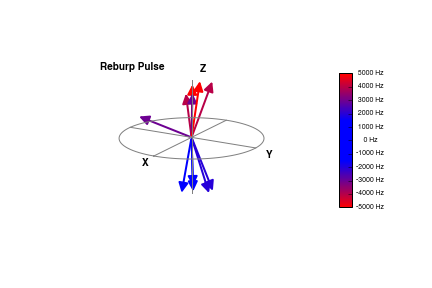
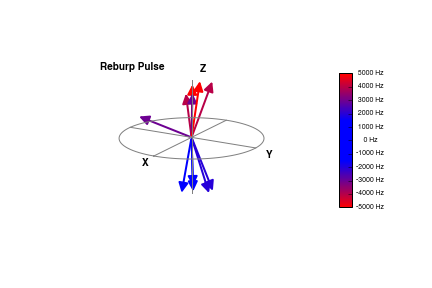

In [16]:
fig = plt.figure()

# Create the fancy spherical axes
elev = 20
azim = 30
ax = circular_axes(fig,'Reburp Pulse', elev, azim)

# Set the starting position of all the arrows
arrowList = []
for x in range(len(relativeomega_S)):
    arrow = Arrow3D([0,0], [0,0], [0,1], mutation_scale=20, lw=2.0, 
                    arrowstyle='-|>', color=colorList[x], label='%.0f Hz'%relativeomega_S[x])
    arrowList.append(arrow)
    ax.add_artist(arrow)

# Option 1: show a colorbar
colorList, scalarMap = omega_colors(relativeomega_S)
scalarMap._A = []
cbar = fig.colorbar(scalarMap, shrink=.6, aspect=10)
cbar.ax.set_yticklabels(['%5.0f Hz'%x for x in relativeomega_S])
# Option 2: show a simple legend
# ax.legend()

# Setup the axis rotation
fpad = 20 # number of frames to pad at the start and finish
mpad = 10 # number of frames to pad in the middle
arotation = np.mod(np.linspace(0, 620., 60) + azim, 360) # azimuthal rotation
apad = len(arotation) # number of frames to pad for azimuthal rotation

# Calculate elevation and azimuthal angles at each time step
azimL = np.tile((azim,), fpad+xyzdata_S.shape[2]+mpad)
azimL = np.append(azimL, arotation)
azimL = np.append(azimL, np.tile((azim,), fpad))
elevL = np.tile((elev,), fpad+xyzdata_S.shape[2]+mpad+apad+fpad)

# Pad the data with starting and finishing values
xyzdata_beg = np.tile(xyzdata_S[:,:,0][:,:,np.newaxis], (1,1,fpad))
xyzdata_end = np.tile(xyzdata_S[:,:,-1][:,:,np.newaxis], (1,1,mpad+apad+fpad))
xyzdata_pad = np.append(xyzdata_beg, xyzdata_S, axis=-1)
xyzdata_pad = np.append(xyzdata_pad, xyzdata_end, axis=-1)

# Do the animation!
anim = FuncAnimation(fig,update_pos, frames=xyzdata_pad.shape[2], 
                     fargs=(xyzdata_pad, arrowList, elevL, azimL), interval=50)
display_animation(anim,default_mode='once')

Note that the arrows representing frequencies within the appropriate bandwidth are all inverted by the pulse. However, the arrows that reside on the edge of the bandwidth or outside of it are not inverted at all. This demonstrates the importance of careful calibration of shaped pulses and the importance of using gradients to clean up stray magnetization whenever possible.

I also think this is a cool animation that would be fun to use for teaching!